In [75]:
# import libraries
import pandas as pd
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score,roc_curve, auc, f1_score,roc_auc_score
from sklearn.linear_model import LogisticRegression
import numpy as np
from scipy.stats import norm
from sklearn.calibration import calibration_curve,CalibrationDisplay
from sklearn.model_selection import GridSearchCV,cross_val_score,RandomizedSearchCV
from sklearn.dummy import DummyClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import brier_score_loss, log_loss
import lightgbm as lgb
import seaborn as sns
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
import catboost as ct
from catboost import CatBoostRegressor, CatBoostClassifier, EShapCalcType, EFeaturesSelectionAlgorithm,Pool
from optbinning import BinningProcess
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
import shap

In [2]:
def logit_pvalue(model, x):
    """ Calculate z-scores for scikit-learn LogisticRegression.
    parameters:
        model: fitted sklearn.linear_model.LogisticRegression with intercept and large C
        x:     matrix on which the model was fit
    This function uses asymtptics for maximum likelihood estimates.
    """
    p = model.predict_proba(x)
    n = len(p)
    m = len(model.coef_[0]) + 1
    coefs = np.concatenate([model.intercept_, model.coef_[0]])
    x_full = np.matrix(np.insert(np.array(x), 0, 1, axis = 1))
    ans = np.zeros((m, m))
    for i in range(n):
        ans = ans + np.dot(np.transpose(x_full[i, :]), x_full[i, :]) * p[i,1] * p[i, 0]
    vcov = np.linalg.inv(np.matrix(ans))
    se = np.sqrt(np.diag(vcov))
    t =  coefs/se  
    p = (1 - norm.cdf(abs(t))) * 2
    return p,se

def pvalue_table(pvalue,SE,data,model):
    var_name=data.columns.tolist()
    var_name.insert(0,'Intercept')
    df_coeff=pd.DataFrame(index=var_name,columns=['Coefficient','Standard_Error','pValue'])
    coeff=model.coef_.tolist()[0]
    coeff.insert(0,model.intercept_.tolist()[0])
    df_coeff['Coefficient']=coeff
    df_coeff['Standard_Error']=SE.tolist()
    df_coeff['pValue']=pvalue.tolist()
    return df_coeff.round(6)




# Functions defined to check the performance of the model
def ks(target=None, prob=None):
    data = pd.DataFrame()
    data['y'] = target
    data['y'] = data['y'].astype(float)
    data['p'] = prob
    data['y0'] = 1- data['y']
    data['bucket'] = pd.qcut(data['p'].rank(method='first'), 5)
    grouped = data.groupby('bucket', as_index=False)
    kstable = pd.DataFrame()
    kstable['min_prob'] = grouped.min()['p']
    kstable['max_prob'] = grouped.max()['p']
    kstable['events'] = grouped.sum()['y']
    kstable['nonevents'] = grouped.sum()['y0']
    kstable = kstable.sort_values(by='min_prob', ascending=False).reset_index(drop=True)
    kstable['event_rate'] = (kstable.events / data['y'].sum()).apply('{0:.2%}'.format)
    kstable['nonevent_rate'] = (kstable['nonevents'] /  data['y0'].sum()).apply('{0:2%}'.format)
    kstable['cum_eventrate'] = (kstable.events / data['y'].sum()).cumsum()
    kstable['cum_noneventrate'] = (kstable.nonevents / data['y0'].sum()).cumsum()
    kstable['KS'] = np.round(kstable['cum_eventrate'] - kstable['cum_noneventrate'], 3) * 100
    kstable['bad_rate'] = (kstable['events'] / (kstable['events'] + kstable['nonevents'])) * 100
    average_event_rate=kstable['events'].sum()/(kstable['events'].sum()+kstable['nonevents'].sum())
    kstable['Lift']=np.round((kstable['bad_rate']/average_event_rate)/100,2)
   
    # formatting
    kstable['cum_eventrate'] = kstable['cum_eventrate'].apply('{0:.2%}'.format)
    kstable['cum_noneventrate'] = kstable['cum_noneventrate'].apply('{0:.2%}'.format)
    kstable.index = range(1,6)
    kstable.index.rename('Decile', inplace=True)
    pd.set_option('display.max_columns', 9)
#     print(kstable)
   
    # Display KS
#     print("KS is " + str(max(kstable['KS']))+"%"+ " at decile " + str((kstable.index[kstable['KS']==max(kstable['KS'])][0])))
#     return kstable
    return max(kstable['KS']),max(kstable['Lift'])

def performance(y_true,y_pred,y_prob):
    #Confusion Matrix
    cmtx = pd.DataFrame(
    confusion_matrix(y_true, y_pred, labels=[0, 1]), 
    index=['true:0', 'true:1'], 
    columns=['pred:0', 'pred:1'])
    print('Confusion Matrix:')
    print(cmtx, '\n')
    
    # FPR, TPR, AUC
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    print('False Positive Rate:', np.round(fpr[1],2))
    print('True Positive Rate:', np.round(tpr[1],2))
#     ks=max(tpr-fpr)
    KS,lift=ks(y_true,y_prob)
#     print('Threshold:',np.round(thresholds,2))
    print("KS:",np.round(KS,2))
    print("Lift:",np.round(lift,2))
    print('AUC:', np.round(auc(fpr, tpr), 2))
    print('ROC_AUC:', np.round(roc_auc_score(y_true,y_prob), 2), '\n')

# Sensitivity, Specificity
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    print('Sensitivity:', np.round(tp/(tp+fn),2))
    print('Specificity:', np.round(tn/(tn+fp),2))
    print('Accuracy Score:', np.round(accuracy_score(y_true,y_pred),2), '\n')

# F1 Score
    print('F1 Score:', np.round(f1_score(y_true, y_pred), 2), '\n')

def performance1(y_true,y_pred,y_prob):
    KS,lift=ks(y_true,y_prob)
    roc_auc= np.round(roc_auc_score(y_true,y_prob), 4)
    ginni=2*roc_auc-1
    ginni=np.round(ginni,2)
    brier=np.round(brier_score_loss(y_true,y_prob),2)
    log=np.round(log_loss(y_true,y_pred),2)
    prob_true, prob_pred=calibration_curve(y_true, y_prob, n_bins=5,strategy='quantile')
    act=np.round([i*100 for i in prob_true],2)
    pred=np.round([i*100 for i in prob_pred],2)
    disp = CalibrationDisplay(prob_true, prob_pred, y_prob)
    df=pd.DataFrame(index=['ROC_AUC','Ginni','KS','Lift','Brier_Score_Loss','Log_Loss','Avg Actual Probability','Avg Predicted Probability'])
    df['Metric']=[roc_auc,ginni,KS,lift,brier,log,act,pred]
    prob_true, prob_pred=calibration_curve(y_true, y_prob, n_bins=5,strategy='quantile')
    disp = CalibrationDisplay(prob_true, prob_pred, y_prob)
    return df
    

    
def ks1(target=None, prob=None):
    data = pd.DataFrame()
    data['y'] = target
    data['y'] = data['y'].astype(float)
    data['p'] = prob
    data['y0'] = 1- data['y']
    data['bucket'] = pd.qcut(data['p'].rank(method='first'), 10)
    grouped = data.groupby('bucket', as_index=False)
    kstable = pd.DataFrame()
    kstable['min_prob'] = grouped.min()['p']
    kstable['max_prob'] = grouped.max()['p']
    kstable['events'] = grouped.sum()['y']
    kstable['nonevents'] = grouped.sum()['y0']
    kstable = kstable.sort_values(by='min_prob', ascending=False).reset_index(drop=True)
    kstable['event_rate'] = (kstable.events / data['y'].sum()).apply('{0:.2%}'.format)
    kstable['nonevent_rate'] = (kstable['nonevents'] /  data['y0'].sum()).apply('{0:2%}'.format)
    kstable['cum_eventrate'] = (kstable.events / data['y'].sum()).cumsum()
    kstable['cum_noneventrate'] = (kstable.nonevents / data['y0'].sum()).cumsum()
    kstable['KS'] = np.round(kstable['cum_eventrate'] - kstable['cum_noneventrate'], 3) * 100
    kstable['bad_rate'] = (kstable['events'] / (kstable['events'] + kstable['nonevents'])) * 100
    average_event_rate=kstable['events'].sum()/(kstable['events'].sum()+kstable['nonevents'].sum())
    kstable['Lift']=np.round((kstable['bad_rate']/average_event_rate)/100,2)
    # formatting
    kstable['cum_eventrate'] = kstable['cum_eventrate'].apply('{0:.2%}'.format)
    kstable['cum_noneventrate'] = kstable['cum_noneventrate'].apply('{0:.2%}'.format)
    kstable.index = range(1,11)
    kstable.index.rename('Decile', inplace=True)
    pd.set_option('display.max_columns', 15)
#     print(kstable)
   
    print("KS is " + str(max(kstable['KS']))+"%"+ " at decile " + str((kstable.index[kstable['KS']==max(kstable['KS'])][0])))
    return kstable


def ks2(target=None, prob=None):
    data = pd.DataFrame()
    data['y'] = target
    data['y'] = data['y'].astype(float)
    data['p'] = prob
    data['y0'] = 1- data['y']
    data['bucket'] = pd.qcut(data['p'].rank(method='first'), 8)
    grouped = data.groupby('bucket', as_index=False)
    kstable = pd.DataFrame()
    kstable['min_prob'] = grouped.min()['p']
    kstable['max_prob'] = grouped.max()['p']
    kstable['events'] = grouped.sum()['y']
    kstable['nonevents'] = grouped.sum()['y0']
    kstable = kstable.sort_values(by='min_prob', ascending=False).reset_index(drop=True)
    # kstable = kstable.sort_values(by='bad_rate', ascending=False).reset_index(drop=True)

    kstable['event_rate'] = (kstable.events / data['y'].sum()).apply('{0:.2%}'.format)
    kstable['nonevent_rate'] = (kstable['nonevents'] /  data['y0'].sum()).apply('{0:2%}'.format)
    kstable['cum_eventrate'] = (kstable.events / data['y'].sum()).cumsum()
    kstable['cum_noneventrate'] = (kstable.nonevents / data['y0'].sum()).cumsum()
    kstable['KS'] = np.round(kstable['cum_eventrate'] - kstable['cum_noneventrate'], 3) * 100
    kstable['bad_rate'] = (kstable['events'] / (kstable['events'] + kstable['nonevents'])) * 100
    average_event_rate=kstable['events'].sum()/(kstable['events'].sum()+kstable['nonevents'].sum())
    kstable['Lift']=np.round((kstable['bad_rate']/average_event_rate)/100,2)
    # formatting
    kstable['cum_eventrate'] = kstable['cum_eventrate'].apply('{0:.2%}'.format)
    kstable['cum_noneventrate'] = kstable['cum_noneventrate'].apply('{0:.2%}'.format)
    kstable.index = range(1,9)
    kstable.index.rename('Decile', inplace=True)
    pd.set_option('display.max_columns', 9)
#     print(kstable)
   
#     Display KS
    print("KS is " + str(max(kstable['KS']))+"%"+ " at decile " + str((kstable.index[kstable['KS']==max(kstable['KS'])][0])))
    # kstable = kstable.sort_values(by='bad_rate', ascending=True).reset_index(drop=True)

    return kstable

In [3]:
df=pd.read_csv("hmda_2017_all.csv")
df.head()

as_of_year respondent_id                                  agency_name  \
0        2017    75-2921540  Department of Housing and Urban Development   
1        2017    0000504713         Consumer Financial Protection Bureau   
2        2017    7810600004  Department of Housing and Urban Development   
3        2017    42-1739728  Department of Housing and Urban Development   
4        2017    42-1739728  Department of Housing and Urban Development   

  agency_abbr  agency_code loan_type_name  loan_type  \
0         HUD            7   Conventional          1   
1        CFPB            9   Conventional          1   
2         HUD            7   Conventional          1   
3         HUD            7   Conventional          1   
4         HUD            7   Conventional          1   

                                  property_type_name  property_type  \
0  One-to-four family dwelling (other than manufa...              1   
1  One-to-four family dwelling (other than manufa...              1   
2  One-to-four family dwelling (other than manufa...              1   
3  One-to-four family dwelling (other than manufa...              1   
4  One-to-four family dwelling (other than manufa...              1   

  loan_purpose_name  ...  edit_status_name edit_status  sequence_number  \
0       Refinancing  ...               NaN         NaN              NaN   
1       Refinancing  ...               NaN         NaN              NaN   
2       Refinancing  ...               NaN         NaN              NaN   
3       Refinancing  ...               NaN         NaN              NaN   
4       Refinancing  ...               NaN         NaN              NaN   

   population minority_population  hud_median_family_income  \
0      3202.0           97.279999                   57400.0   
1      3733.0            4.580000                   63900.0   
2      5498.0           37.919998                   75400.0   
3      3566.0           11.830000                   55200.0   
4      2910.0           48.660000                   77500.0   

  tract_to_msamd_income  number_of_owner_occupied_units  \
0             47.540001                           710.0   
1             86.239998                           861.0   
2             63.939999                          1270.0   
3             74.290001                           573.0   
4             79.250000                           599.0   

  number_of_1_to_4_family_units  application_date_indicator  
0                        1314.0                         NaN  
1                        1241.0                         NaN  
2                        1658.0                         NaN  
3                        1261.0                         NaN  
4                          26.0                         NaN  

[5 rows x 78 columns]

## 1. Exploratory Data Analysis

In [9]:
# Dataset Structure Summary
print("Dataset Shape:", df.shape)
# print("\nColumns:\n", df.columns.tolist())
print("\nData Types:\n", df.dtypes)

Dataset Shape: (14285496, 78)

Data Types:
 as_of_year                          int64
respondent_id                      object
agency_name                        object
agency_abbr                        object
agency_code                         int64
                                   ...   
hud_median_family_income          float64
tract_to_msamd_income             float64
number_of_owner_occupied_units    float64
number_of_1_to_4_family_units     float64
application_date_indicator        float64
Length: 78, dtype: object


### 1.1 Missing Value Check

In [11]:
# Missing Value Check
missing = df.isnull().sum()
missing = missing[missing > 0]
print("\n Missing Values:\n", missing)


 Missing Values:
 loan_amount_000s                      5036
msamd_name                         1794478
msamd                              1791050
state_name                          197158
state_abbr                          197158
state_code                          197158
county_name                         245684
county_code                         245597
census_tract_number                 284302
applicant_race_name_2             14195114
applicant_race_2                  14195114
applicant_race_name_3             14278506
applicant_race_3                  14278506
applicant_race_name_4             14283852
applicant_race_4                  14283852
applicant_race_name_5             14284412
applicant_race_5                  14284412
co_applicant_race_name_2          14255082
co_applicant_race_2               14255082
co_applicant_race_name_3          14283352
co_applicant_race_3               14283352
co_applicant_race_name_4          14284832
co_applicant_race_4               1

### 1.2 Summary Statistics

In [16]:
# Descriptive Statistics
summary_stats = df.describe().T
print("\nSummary Statistics:\n")
summary_stats


Summary Statistics:



count          mean           std  \
as_of_year                      14285496.0   2017.000000      0.000000   
agency_code                     14285496.0      6.809450      2.122487   
loan_type                       14285496.0      1.439923      0.746708   
property_type                   14285496.0      1.044156      0.222409   
loan_purpose                    14285496.0      1.845050      0.948454   
owner_occupancy                 14285496.0      1.102287      0.317221   
loan_amount_000s                14280460.0    248.083578   1481.112563   
preapproval                     14285496.0      2.796495      0.479047   
action_taken                    14285496.0      2.627451      1.931120   
msamd                           12494446.0  30458.408089  11328.080211   
state_code                      14088338.0     27.055583     16.654726   
county_code                     14039899.0     85.518500     99.260622   
census_tract_number             14001194.0   2215.632883   3207.870495   
applicant_ethnicity             14285496.0      2.226901      0.759177   
co_applicant_ethnicity          14285496.0      3.758975      1.432626   
applicant_race_1                14285496.0      5.006299      1.175715   
applicant_race_2                   90382.0      4.396572      1.087291   
applicant_race_3                    6990.0      4.298426      1.082879   
applicant_race_4                    1644.0      4.170316      0.762125   
applicant_race_5                    1084.0      4.752768      0.899236   
co_applicant_race_1             14285496.0      6.684319      1.608004   
co_applicant_race_2                30414.0      4.445486      1.055073   
co_applicant_race_3                 2144.0      4.251399      1.038569   
co_applicant_race_4                  664.0      4.353916      0.766798   
co_applicant_race_5                  349.0      4.756447      0.891044   
applicant_sex                   14285496.0      1.715934      0.986755   
co_applicant_sex                14285496.0      3.696801      1.513284   
applicant_income_000s           12389632.0    114.220041   2134.008457   
purchaser_type                  14285496.0      1.694977      2.475861   
denial_reason_1                  1411970.0      3.803555      2.512255   
denial_reason_2                   305152.0      4.182017      2.609622   
denial_reason_3                    49338.0      5.053833      2.680472   
rate_spread                       493273.0      2.473063      1.441981   
hoepa_status                    14285496.0      1.999748      0.015879   
lien_status                     14285496.0      1.522989      1.087268   
edit_status_name                       0.0           NaN           NaN   
edit_status                            0.0           NaN           NaN   
sequence_number                        0.0           NaN           NaN   
population                      14001188.0   5720.963936   3170.170883   
minority_population             14001144.0     32.731878     26.185145   
hud_median_family_income        14001188.0  70833.474852  14949.264610   
tract_to_msamd_income           14001188.0    113.023629     40.887929   
number_of_owner_occupied_units  14001144.0   1465.339805    886.235782   
number_of_1_to_4_family_units   14001144.0   2004.187703   1099.152136   
application_date_indicator             0.0           NaN           NaN   

                                    min           25%           50%  \
as_of_year                       2017.0   2017.000000   2017.000000   
agency_code                         1.0      7.000000      7.000000   
loan_type                           1.0      1.000000      1.000000   
property_type                       1.0      1.000000      1.000000   
loan_purpose                        1.0      1.000000      1.000000   
owner_occupancy                     1.0      1.000000      1.000000   
loan_amount_000s                    1.0    112.000000    185.000000   
preapproval                         1.0      3.000000      3.000

### 1.3 Target Creation

In [7]:
# Keep only completed credit decisions
df = df[df['action_taken'].isin([1, 2, 3])].copy()
df['target'] = df['action_taken'].isin([1, 2]).astype(int)

### 1.4 Inital Features

In [9]:
loan_feat=['loan_amount_000s','loan_type','loan_purpose','property_type','lien_status','preapproval','owner_occupancy']
app_feat=['applicant_income_000s']
geo_feat=['census_tract_number','msamd','minority_population','tract_to_msamd_income','hud_median_family_income','number_of_owner_occupied_units','number_of_1_to_4_family_units']

In [10]:
full_feat=loan_feat+app_feat+geo_feat

In [11]:
full_feat  # Total 15 featurea

['loan_amount_000s',
 'loan_type',
 'loan_purpose',
 'property_type',
 'lien_status',
 'preapproval',
 'owner_occupancy',
 'applicant_income_000s',
 'census_tract_number',
 'msamd',
 'minority_population',
 'tract_to_msamd_income',
 'hud_median_family_income',
 'number_of_owner_occupied_units',
 'number_of_1_to_4_family_units']

In [21]:
# Create an empty list to store each row as a dictionary
dq_rows = []

# Select relevant columns (exclude IDs and target)
columns_to_check = [
    col for col in df[full_feat].columns
    if col not in []
]

# Loop through each column and calculate statistics
for col in columns_to_check:
    total = len(df)
    missing_pct = df[col].isna().mean() * 100
    zero_pct = (df[col] == 0).mean() * 100 if pd.api.types.is_numeric_dtype(df[col]) else np.nan
    negative_pct = (df[col] < 0).mean() * 100 if pd.api.types.is_numeric_dtype(df[col]) else np.nan
    unique_vals = df[col].nunique()
    dtype = df[col].dtype

    dq_rows.append({
        "Feature": col,
        "Missing_Values (%)": round(missing_pct, 2),
        "Zero_Values (%)": round(zero_pct, 2) if not pd.isna(zero_pct) else '',
        "Negative_Values (%)": round(negative_pct, 2) if not pd.isna(negative_pct) else '',
        "Unique_Values": unique_vals,
        "Data_Type": str(dtype)
    })

# Convert list of dicts to DataFrame
dq_summary = pd.DataFrame(dq_rows)

# Display the result
display(dq_summary)


Feature  Missing_Values (%)  Zero_Values (%)  \
0                 loan_amount_000s                0.03             0.00   
1                        loan_type                0.00             0.00   
2                     loan_purpose                0.00             0.00   
3                    property_type                0.00             0.00   
4                      lien_status                0.00             0.00   
5                      preapproval                0.00             0.00   
6                  owner_occupancy                0.00             0.00   
7            applicant_income_000s                5.69             0.00   
8              census_tract_number                0.89             0.00   
9                            msamd               12.21             0.00   
10             minority_population                0.89             0.05   
11           tract_to_msamd_income                0.89             0.10   
12        hud_median_family_income                0.89             0.00   
13  number_of_owner_occupied_units                0.89             0.01   
14   number_of_1_to_4_family_units                0.89             0.01   

    Negative_Values (%)  Unique_Values Data_Type  
0                   0.0           8417   float64  
1                   0.0              4     int64  
2                   0.0              3     int64  
3                   0.0              3     int64  
4                   0.0              3     int64  
5                   0.0              3     int64  
6                   0.0              3     int64  
7                   0.0           6268   float64  
8                   0.0          23818   float64  
9                   0.0            685   float64  
10                  0.0           9891   float64  
11                  0.0          17173   float64  
12                  0.0            297   float64  
13                  0.0           3356   float64  
14                  0.0           4329   float64

### 1.5 Treating Missing Values

In [16]:
df['income_missing'] = df['applicant_income_000s'].isnull().astype(int)
df['applicant_income_000s'] = df['applicant_income_000s'].fillna(
    df['applicant_income_000s'].median()
)

df['msamd'] = df['msamd'].fillna('Non_MSA')

census_cols = [
    'minority_population',
    'number_of_owner_occupied_units',
    'number_of_1_to_4_family_units',
    'tract_to_msamd_income',
    'hud_median_family_income',
    'census_tract_number'
]

for col in census_cols:
    df[col + '_missing'] = df[col].isnull().astype(int)
    df[col] = df[col].fillna(df[col].median())


df['loan_amount_000s'] = (
    df['loan_amount_000s']
    .fillna(df['loan_amount_000s'].median())
)

### 1.6 Plots - Feature Distribution, Box plots, Heatmap (Correlation analysis)

In [25]:
data=df[full_feat].copy()
data['target']=df['target']

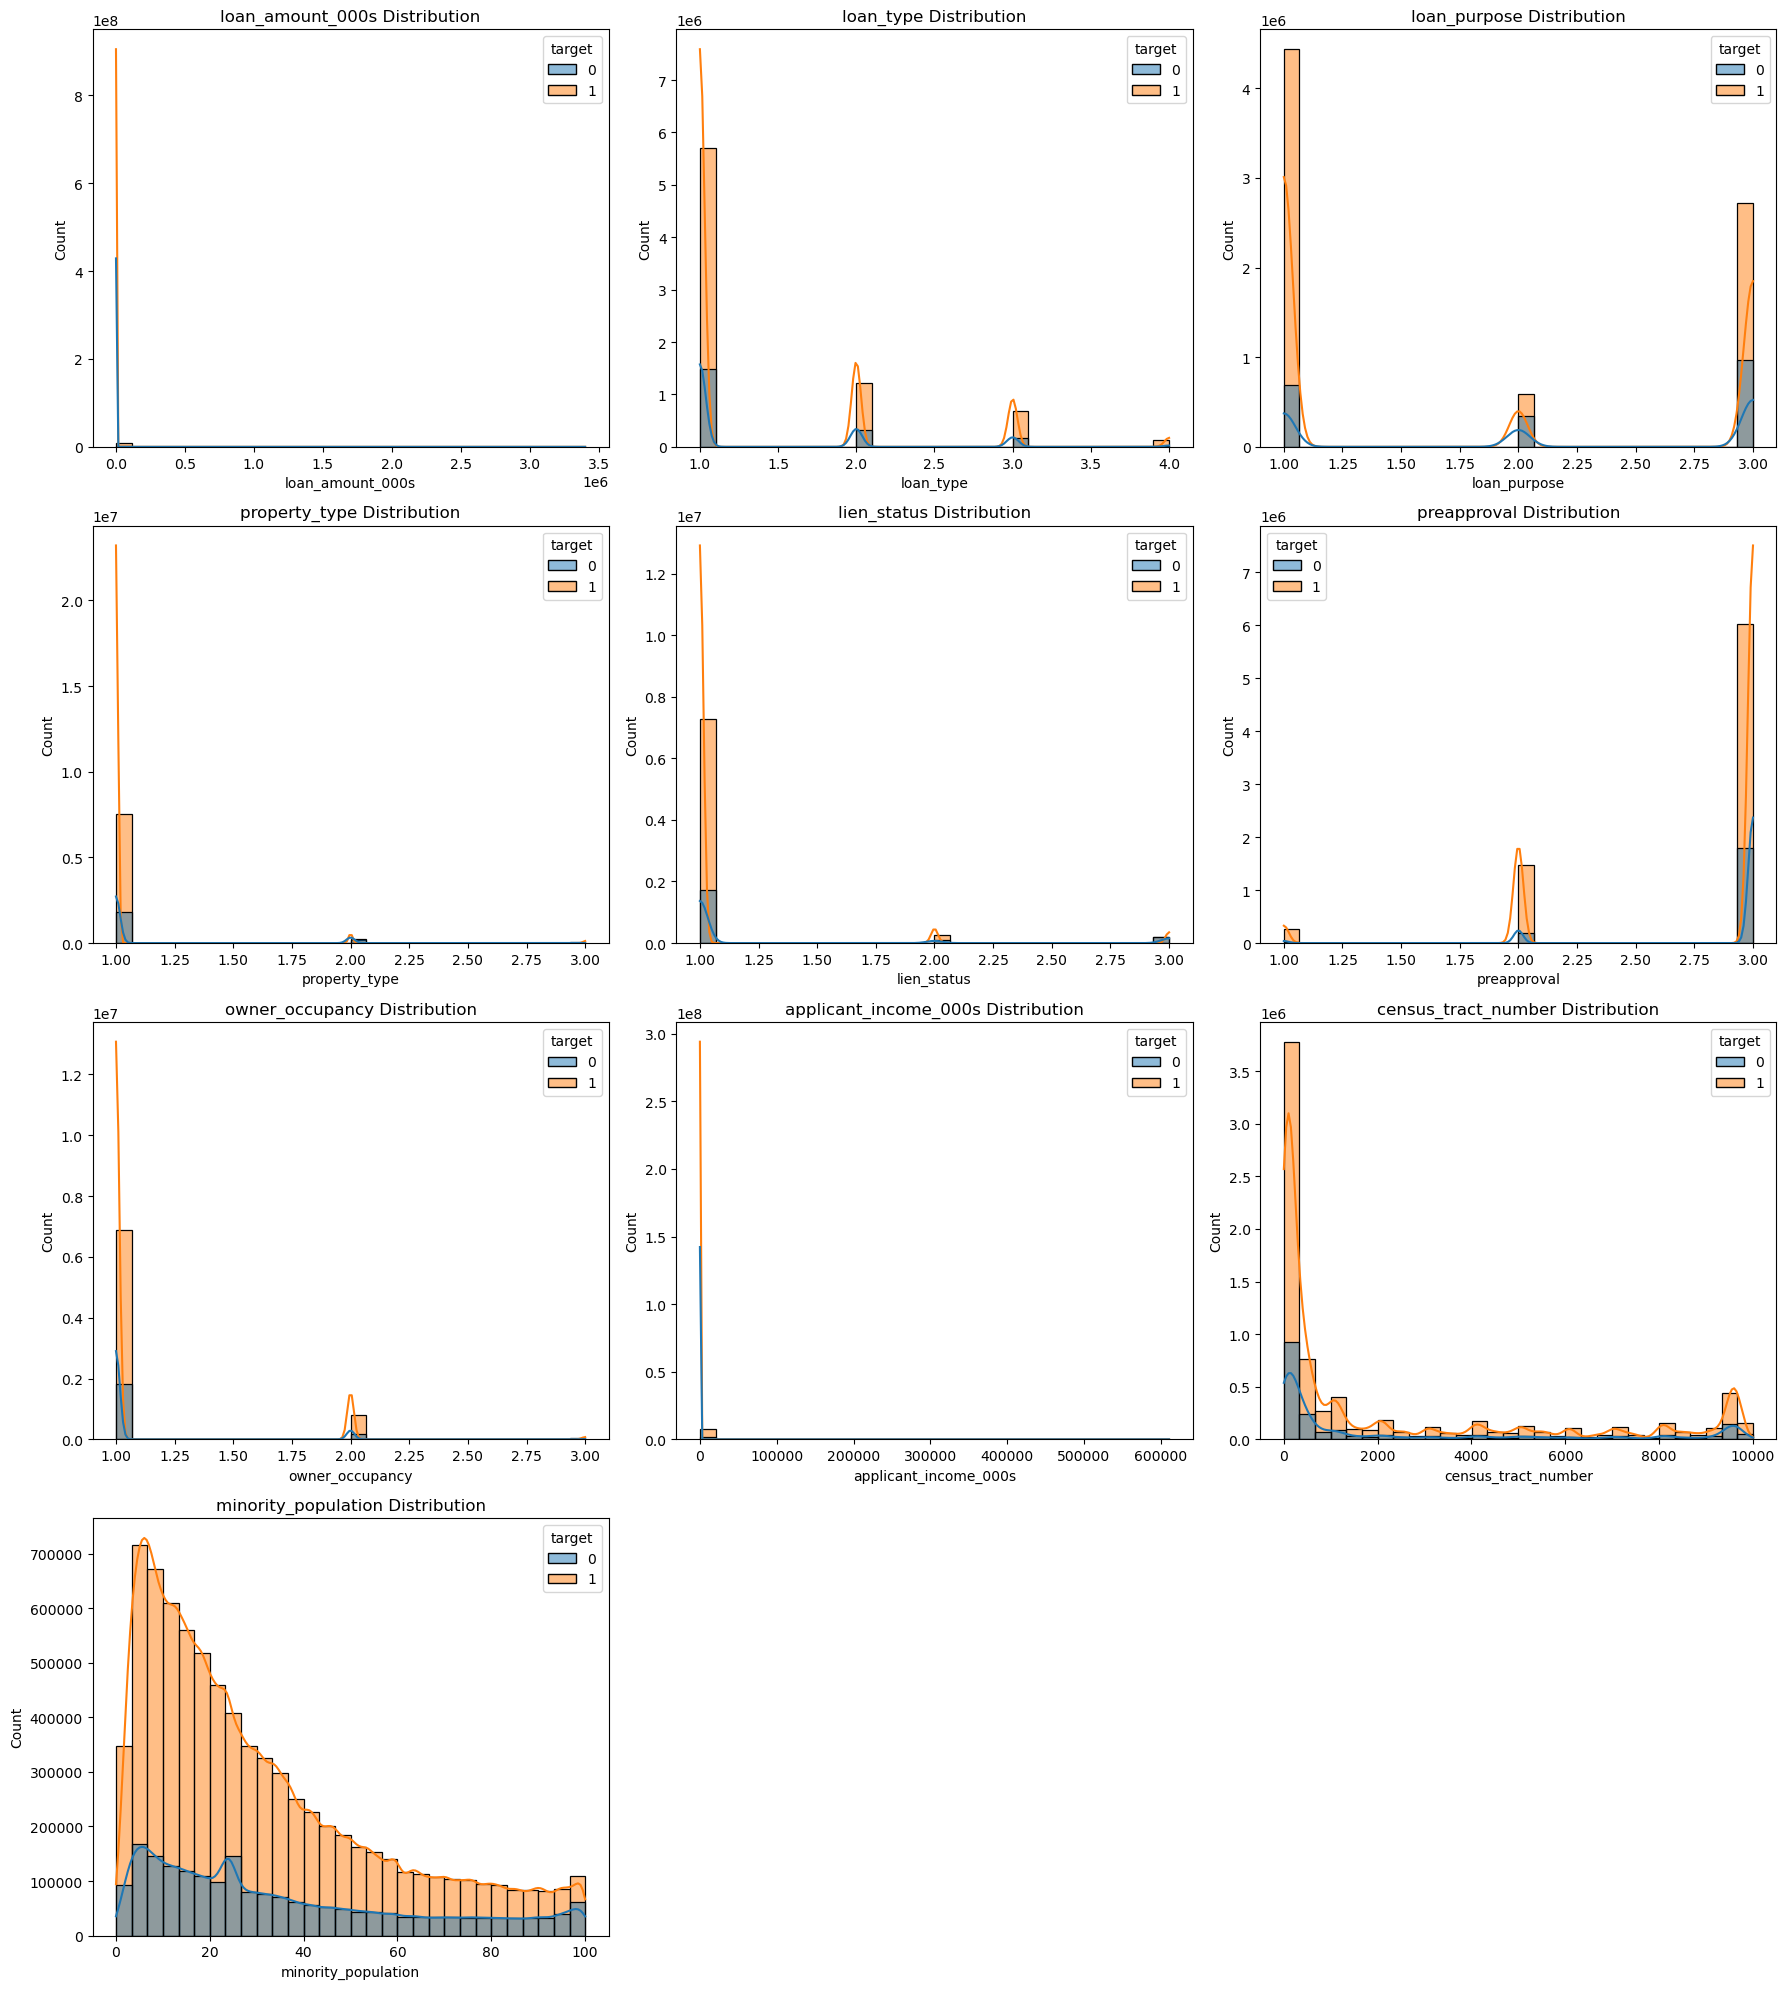

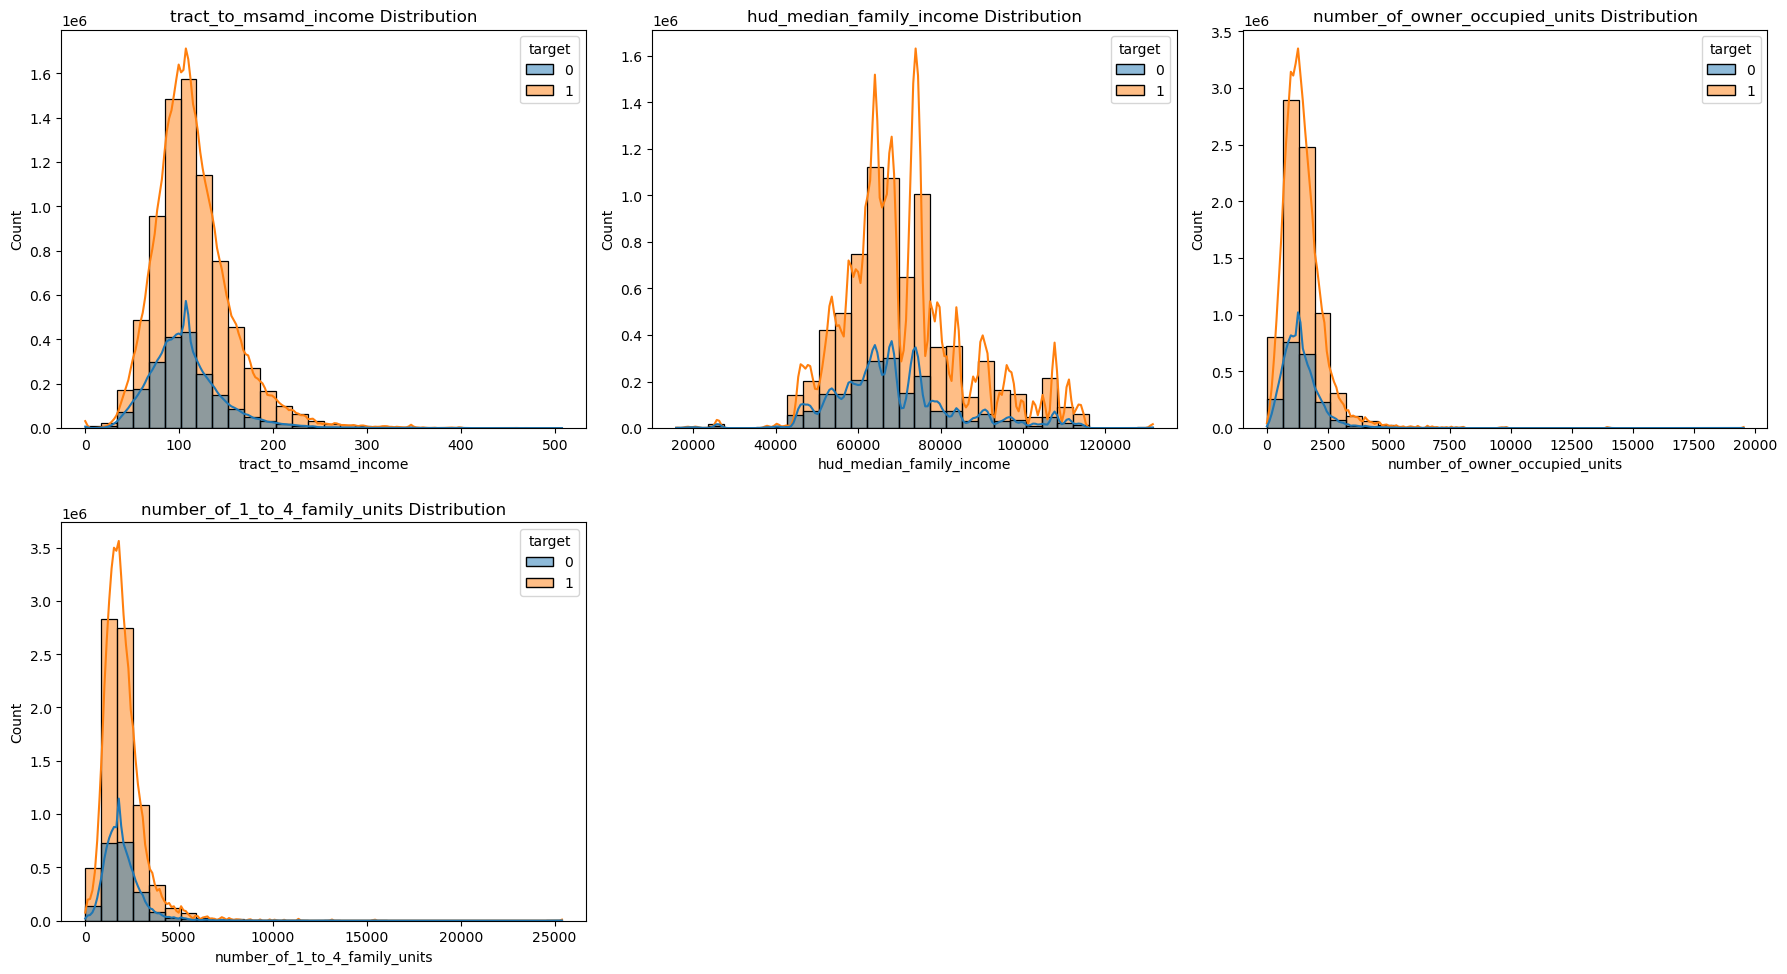

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_distributions(data, features, target="target", batch_size=10):
    for i in range(0, len(features), batch_size):
        batch = features[i:i+batch_size]
        n = len(batch)
        fig, axes = plt.subplots(nrows=(n + 2) // 3, ncols=3, figsize=(18, 5 * ((n + 2) // 3)))
        axes = axes.flatten()
        for j, col in enumerate(batch):
            if data[col].nunique() <= 2:
                sns.countplot(x=col, hue=target, data=data, ax=axes[j])
            else:
                sns.histplot(data=data, x=col, hue=target, kde=True, bins=30, ax=axes[j])
            axes[j].set_title(f"{col} Distribution")
        for k in range(j + 1, len(axes)):
            fig.delaxes(axes[k])
        plt.tight_layout()
        plt.show()

# Usage
plot_features = [col for col in data.columns if col not in ['target']]
plot_features = [col for col in plot_features if pd.api.types.is_numeric_dtype(data[col])]

plot_distributions(df, plot_features, batch_size=10)


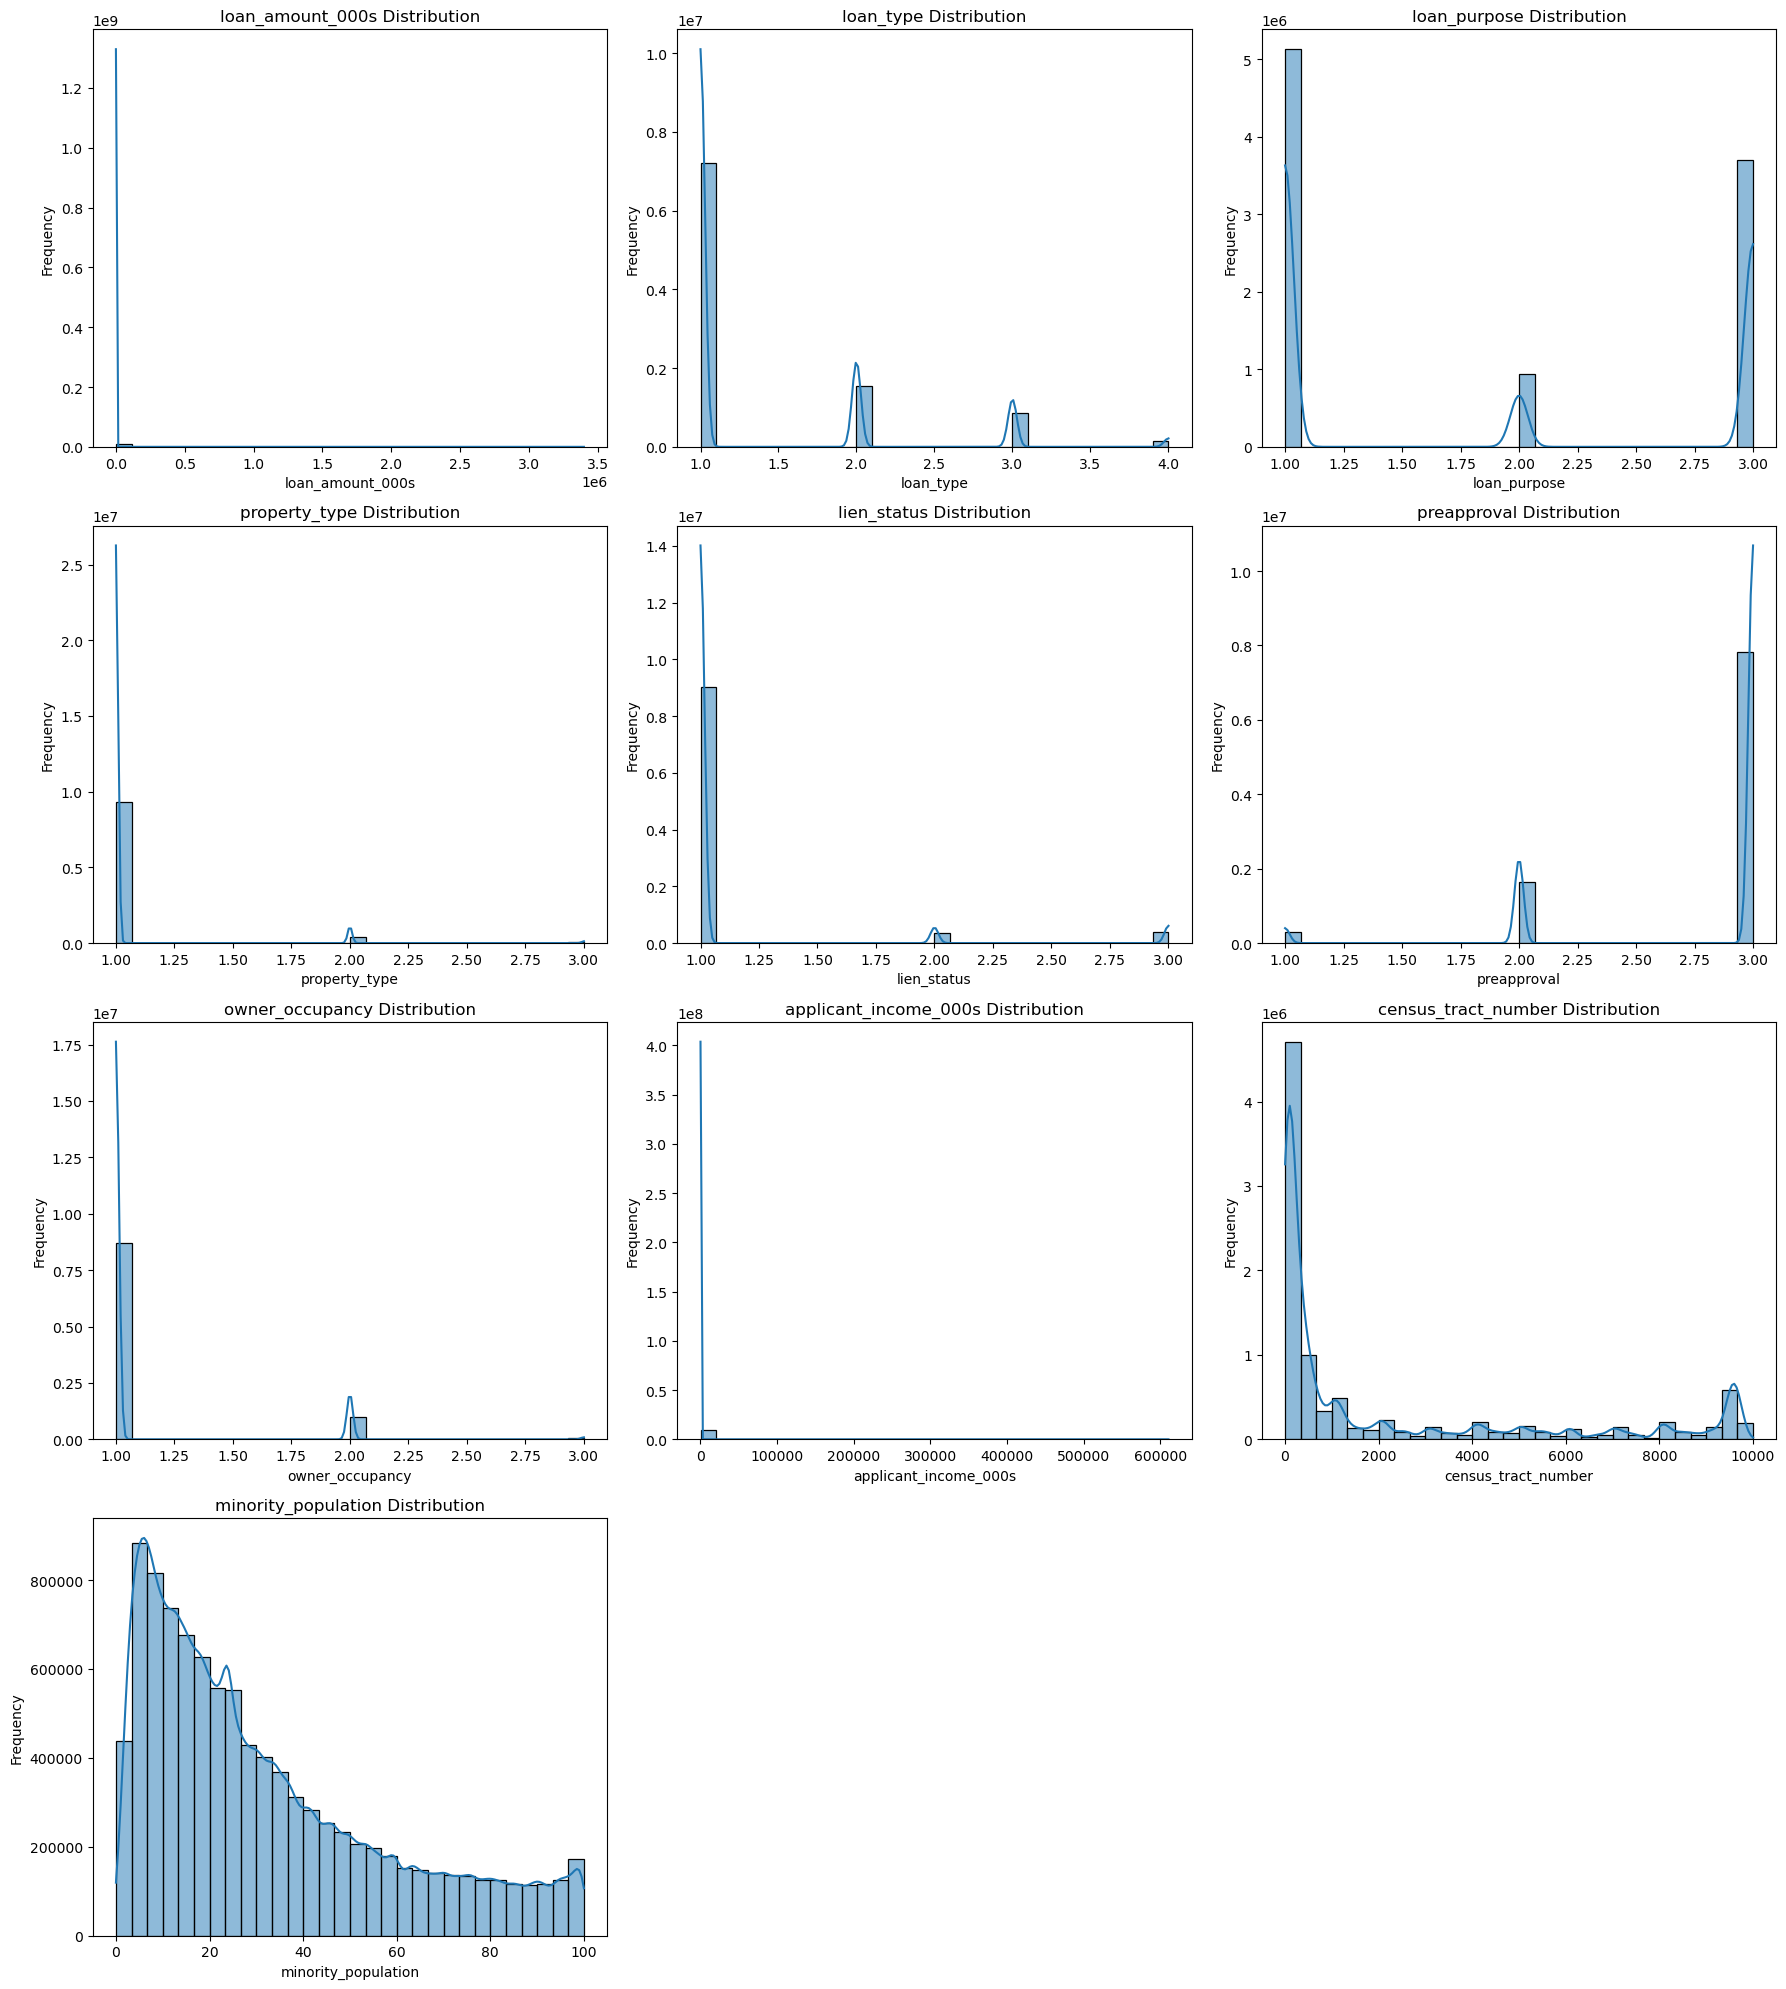

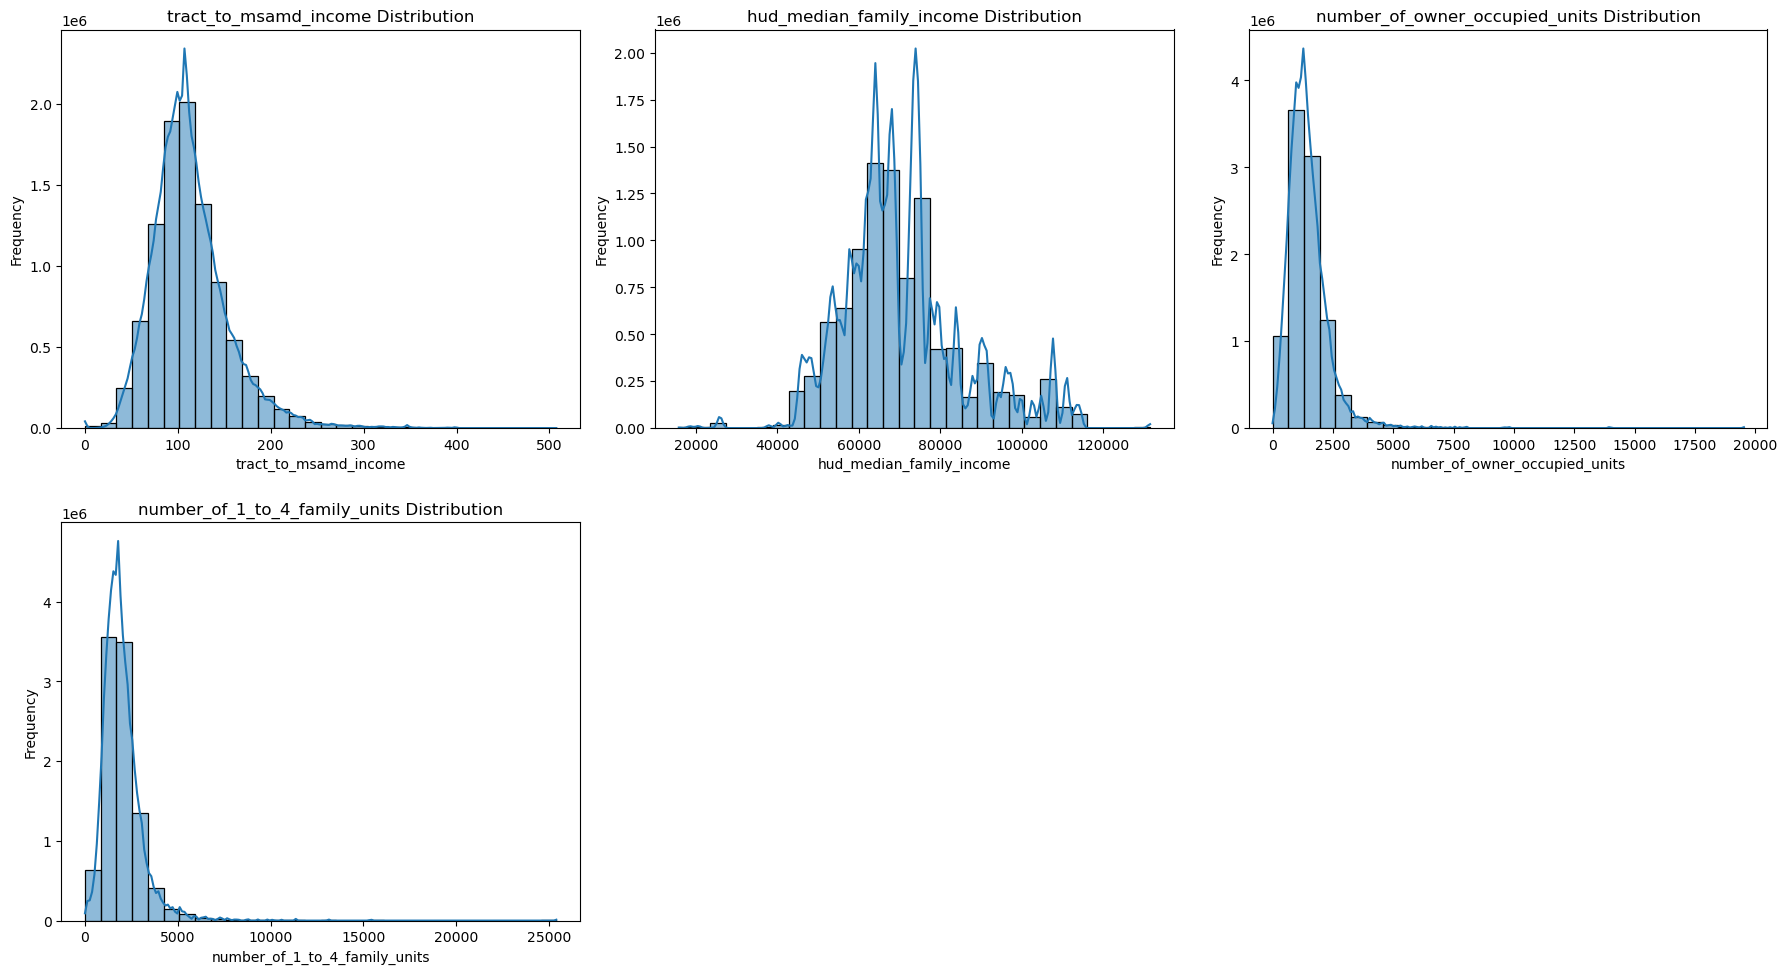

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_feature_distributions(df, features, batch_size=10):
    total = len(features)
    for i in range(0, total, batch_size):
        batch = features[i:i+batch_size]
        n = len(batch)
        fig, axes = plt.subplots(nrows=(n + 2)//3, ncols=3, figsize=(18, 5 * ((n + 2)//3)))
        axes = axes.flatten()
        for j, col in enumerate(batch):
            sns.histplot(df[col], bins=30, kde=True, ax=axes[j])
            axes[j].set_title(f"{col} Distribution")
            axes[j].set_xlabel(col)
            axes[j].set_ylabel("Frequency")
        for k in range(j + 1, len(axes)):
            fig.delaxes(axes[k])
        plt.tight_layout()
        plt.show()

# Identify numeric features (excluding ID/date/target)
plot_features = [col for col in data.columns if col not in ['target']]
plot_features = [col for col in plot_features if pd.api.types.is_numeric_dtype(data[col])]

# Plot in batches of 10
plot_feature_distributions(df, plot_features, batch_size=10)


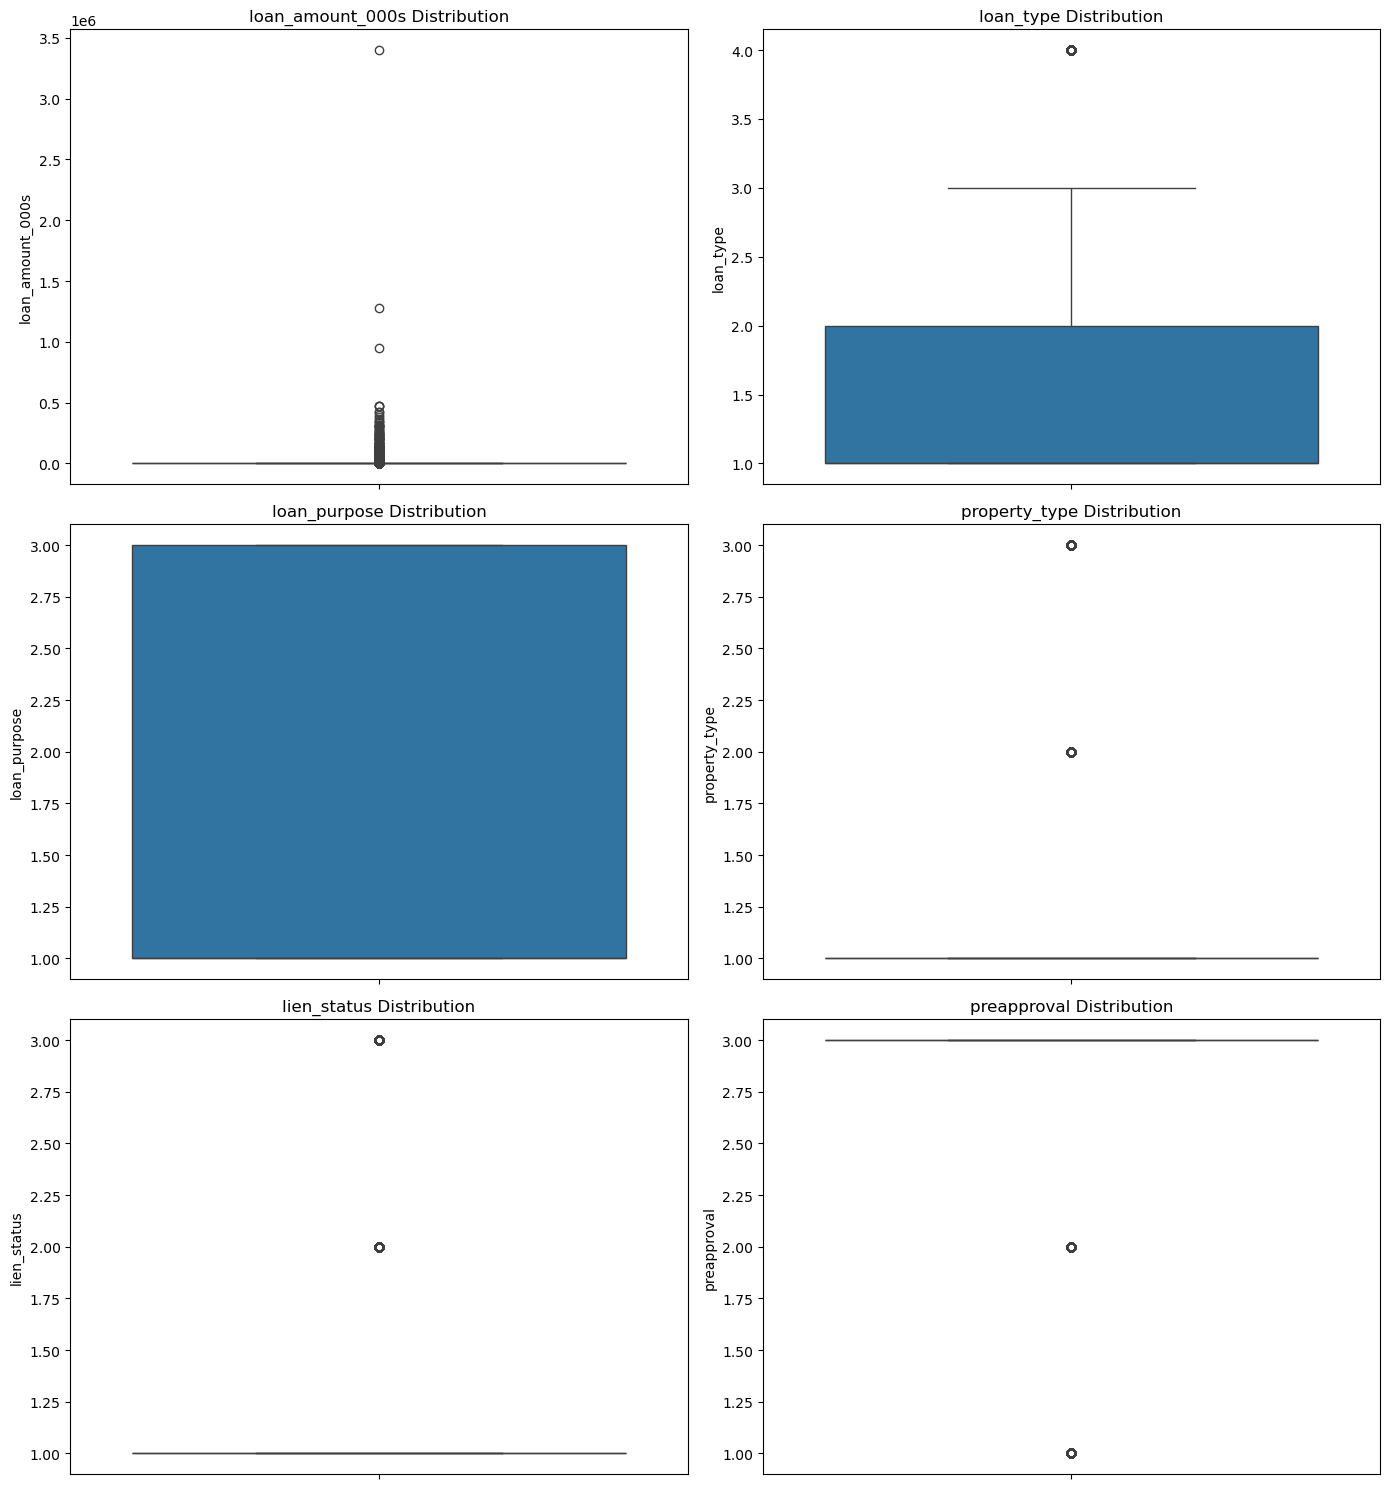

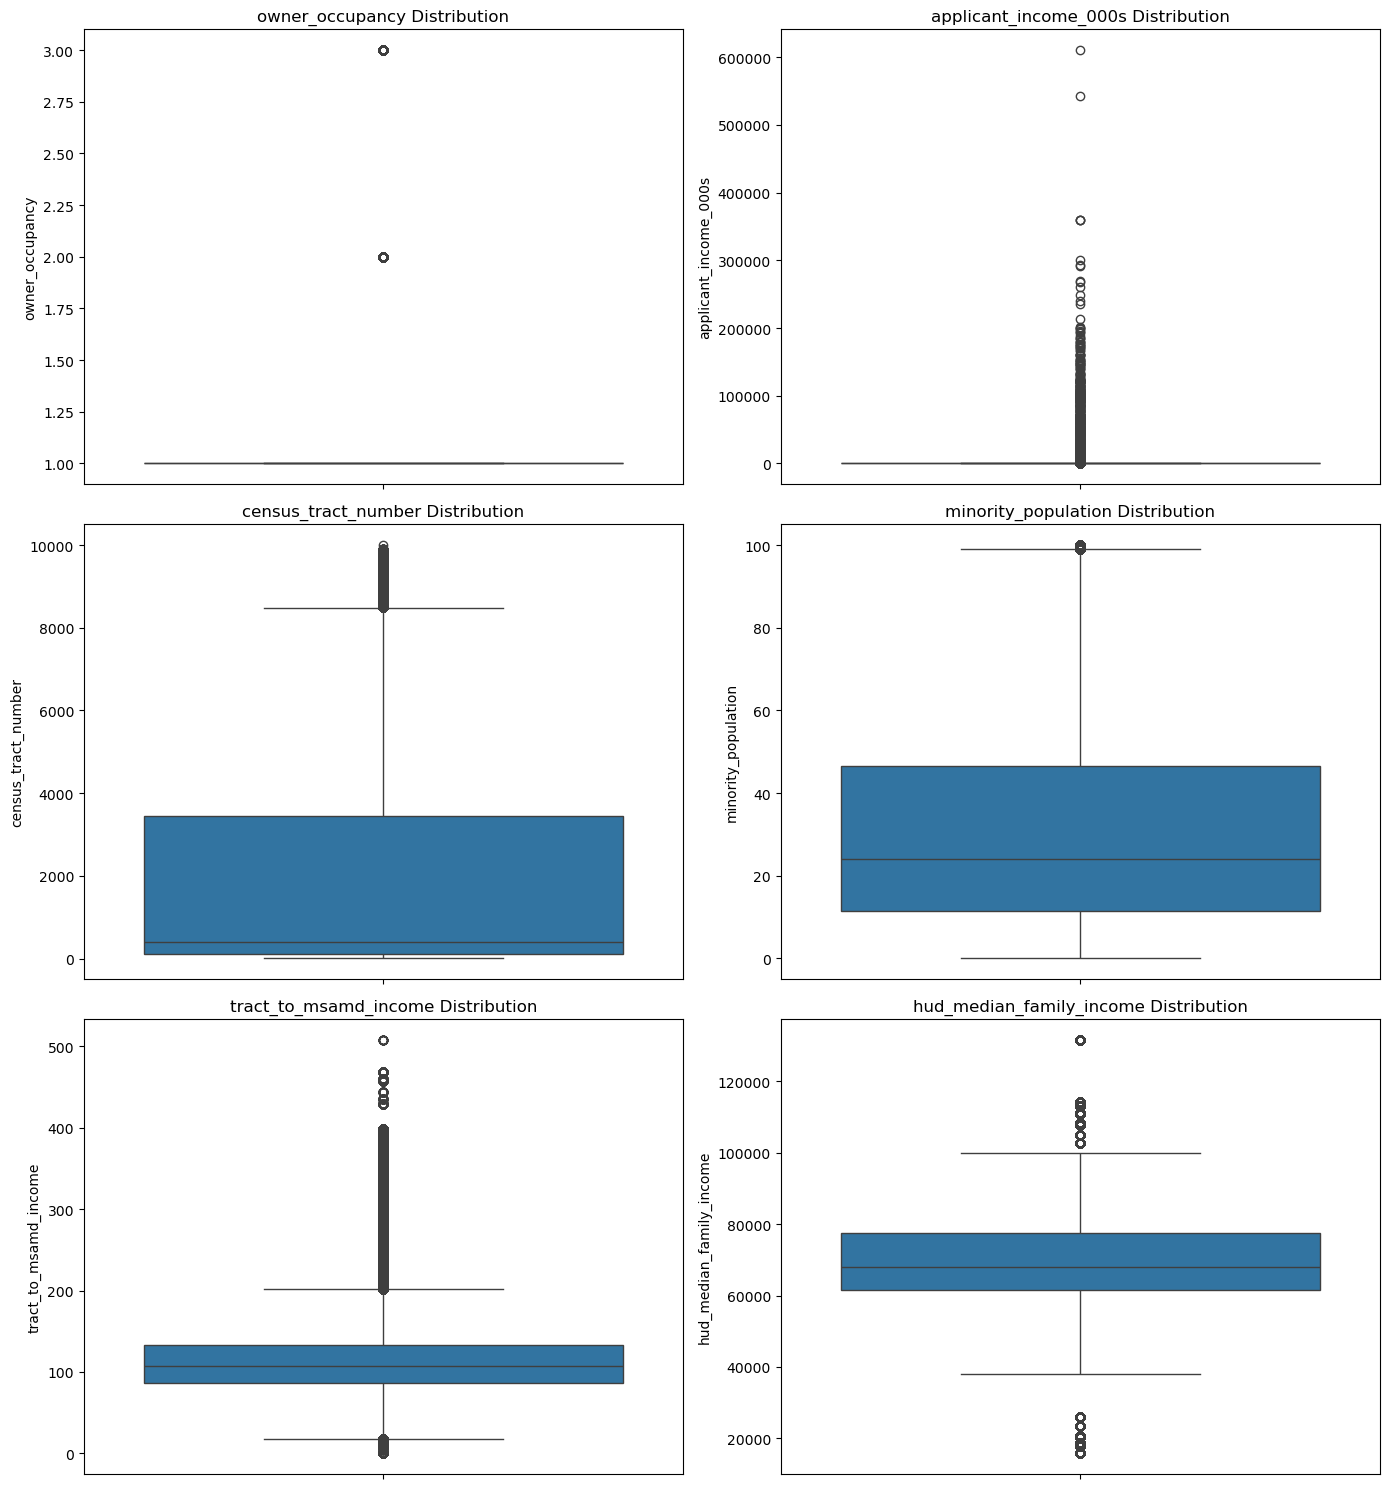

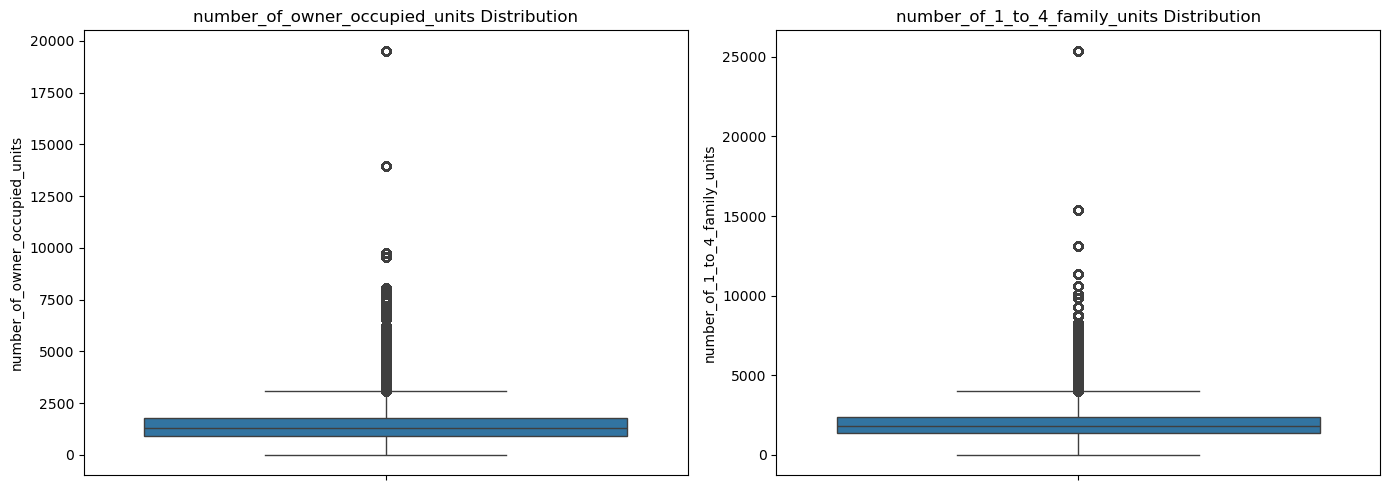

In [58]:
# Function to plot boxplots for numeric features (no target involved)
def plot_individual_boxplots(df, features, batch_size=6):
    total = len(features)
    for i in range(0, total, batch_size):
        batch = features[i:i+batch_size]
        n = len(batch)
        fig, axes = plt.subplots(nrows=(n + 1) // 2, ncols=2, figsize=(14, 5 * ((n + 1) // 2)))
        axes = axes.flatten()
        for j, col in enumerate(batch):
            sns.boxplot(y=df[col], ax=axes[j])
            axes[j].set_title(f"{col} Distribution")
            axes[j].set_ylabel(col)
        # Remove unused axes
        for k in range(j + 1, len(axes)):
            fig.delaxes(axes[k])
        plt.tight_layout()
        plt.show()

# Select numeric features (excluding identifiers and target)
numeric_features = [
    col for col in data.columns
    if col not in ['target']
    and pd.api.types.is_numeric_dtype(data[col])
]

# Call the function
plot_individual_boxplots(data, numeric_features, batch_size=6)

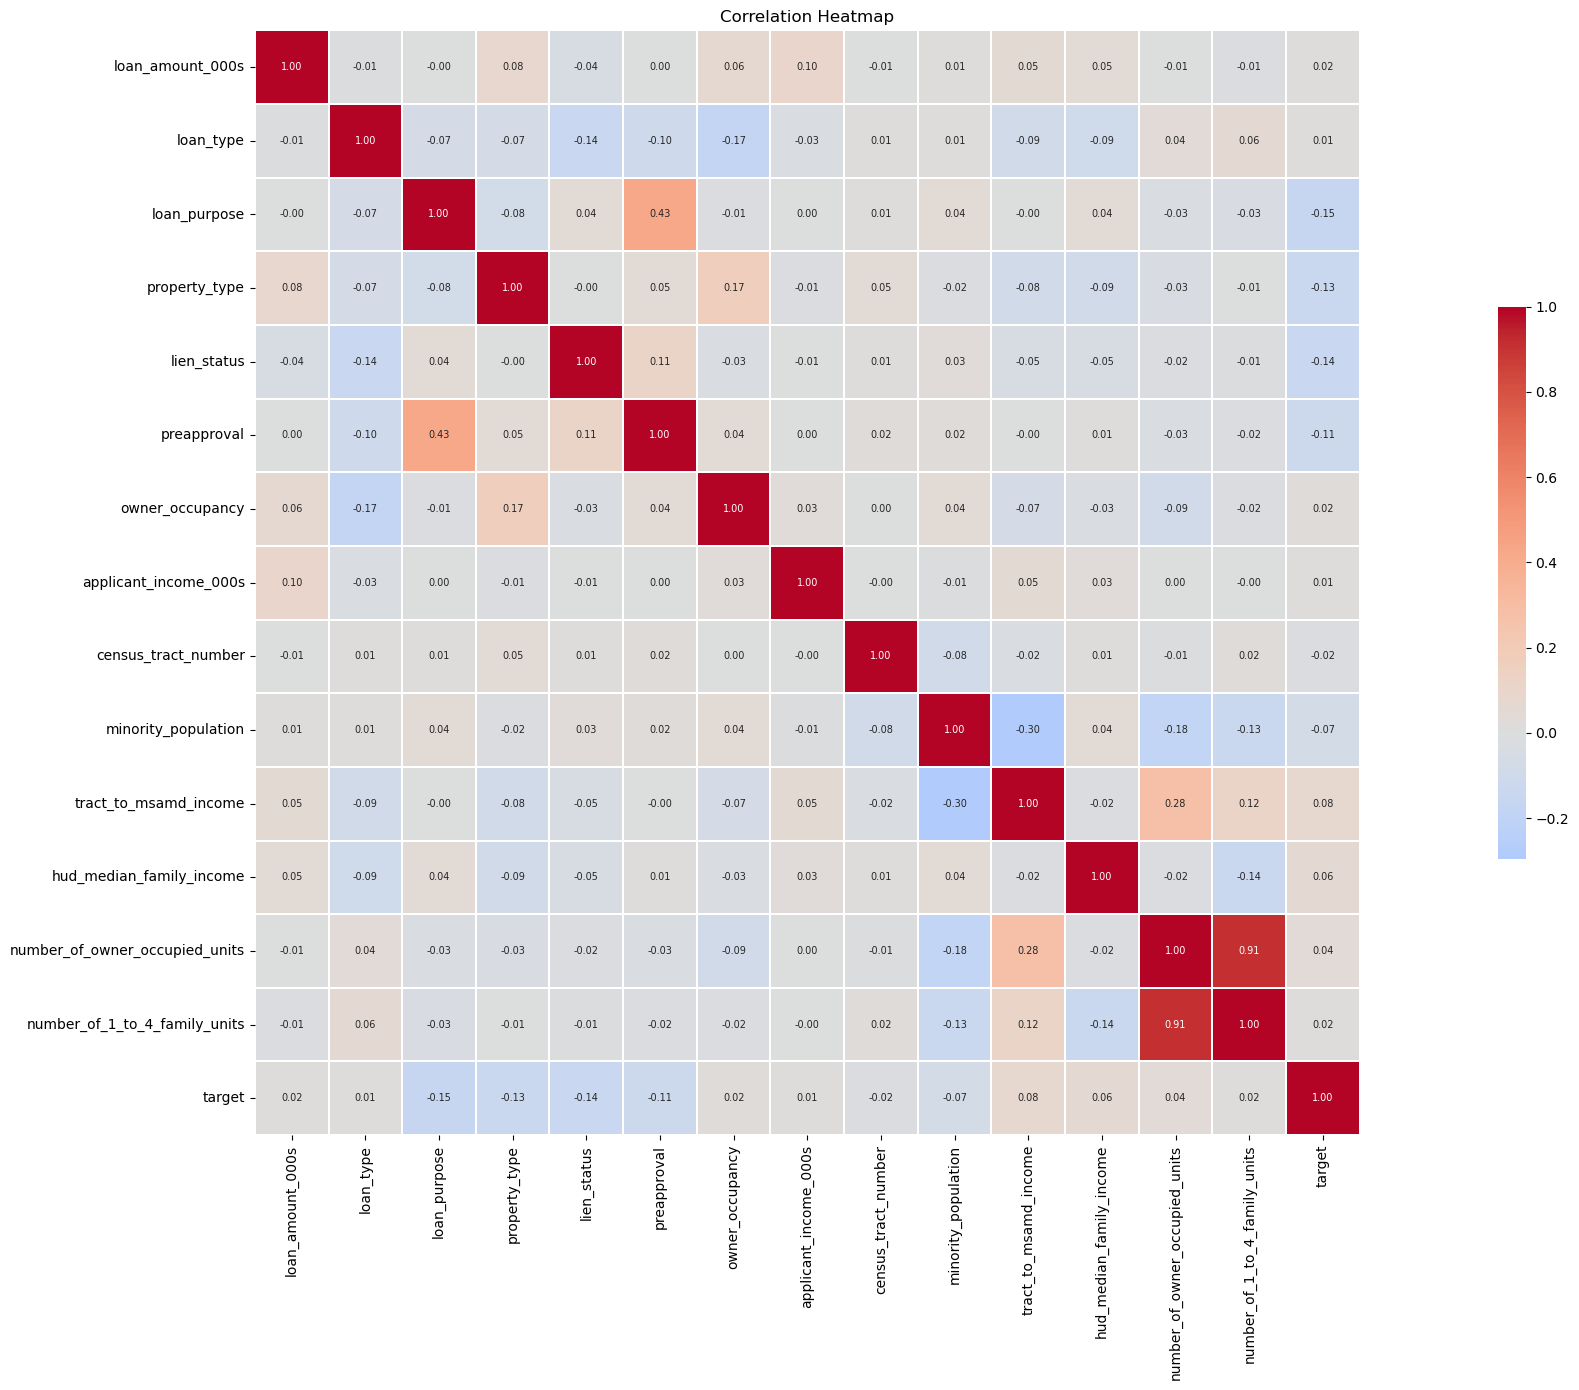

In [62]:
# Compute full correlation matrix

corr_matrix = data.corr(numeric_only=True)

# Plot the correlation heatmap
plt.figure(figsize=(28, 14))  

sns.heatmap(
    corr_matrix,
    cmap="coolwarm",         
    center=0,               
    square=True,             
    linewidths=0.3,          
    cbar_kws={"shrink": 0.5},
    annot=True,              
    fmt=".2f",               
    annot_kws={"size": 7}    
)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

In [64]:
corr_matrix

loan_amount_000s  loan_type  loan_purpose  \
loan_amount_000s                        1.000000  -0.010769     -0.004709   
loan_type                              -0.010769   1.000000     -0.065511   
loan_purpose                           -0.004709  -0.065511      1.000000   
property_type                           0.080553  -0.065528     -0.082090   
lien_status                            -0.037961  -0.142210      0.040772   
preapproval                             0.000027  -0.102986      0.427368   
owner_occupancy                         0.064717  -0.169073     -0.012291   
applicant_income_000s                   0.098797  -0.026061      0.003140   
census_tract_number                    -0.006742   0.009837      0.014210   
minority_population                     0.010169   0.014128      0.044759   
tract_to_msamd_income                   0.049703  -0.089757     -0.002522   
hud_median_family_income                0.046011  -0.093733      0.041726   
number_of_owner_occupied_units         -0.006718   0.036944     -0.030430   
number_of_1_to_4_family_units          -0.014714   0.060442     -0.034826   
target                                  0.017126   0.009801     -0.154475   

                                property_type  lien_status  preapproval  \
loan_amount_000s                     0.080553    -0.037961     0.000027   
loan_type                           -0.065528    -0.142210    -0.102986   
loan_purpose                        -0.082090     0.040772     0.427368   
property_type                        1.000000    -0.002402     0.047942   
lien_status                         -0.002402     1.000000     0.110796   
preapproval                          0.047942     0.110796     1.000000   
owner_occupancy                      0.166910    -0.031153     0.040720   
applicant_income_000s               -0.014595    -0.005212     0.002779   
census_tract_number                  0.047043     0.014678     0.020912   
minority_population                 -0.015737     0.028755     0.018923   
tract_to_msamd_income               -0.083781    -0.046874    -0.003259   
hud_median_family_income            -0.089742    -0.046831     0.009039   
number_of_owner_occupied_units      -0.034303    -0.016862    -0.025775   
number_of_1_to_4_family_units       -0.006683    -0.010790    -0.022000   
target                              -0.132283    -0.144555    -0.114047   

                                owner_occupancy  applicant_income_000s  \
loan_amount_000s                       0.064717               0.098797   
loan_type                             -0.169073              -0.026061   
loan_purpose                          -0.012291               0.003140   
property_type                          0.166910              -0.014595   
lien_status                           -0.031153              -0.005212   
preapproval                            0.040720               0.002779   
owner_occupancy                        1.000000               0.025044   
applicant_income_000s                  0.025044               1.000000   
census_tract_number                    0.001930              -0.001795   
minority_population                    0.043667              -0.007184   
tract_to_msamd_income                 -0.067313               0.049573   
hud_median_family_income              -0.027623               0.027749   
number_of_owner_occupied_units        -0.088341               0.001395   
number_of_1_to_4_family_units         -0.020519              -0.003865   
target                                 0.023138               0.014152   

                                census_tract_number  minority_population  \
loan_amount_000s                          -0.006742             0.010169   
loan_type                                  0.009837             0.014128   
loan_purpose                               0.014210             0.044759   
property_type                              0.047043            -0.015737   
lien_status                      

In [ ]:
loan_amount_000s,applicant_income_000s

### 1.7 Outlier Treatment

In [29]:
# # Function to cap outliers based on IQR method
# def cap_outliers_iqr(df, features):
#     df_capped = df.copy()
#     for col in features:
#         if pd.api.types.is_numeric_dtype(df_capped[col]):
#             Q1 = df_capped[col].quantile(0.25)
#             Q3 = df_capped[col].quantile(0.75)
#             IQR = Q3 - Q1
#             lower_bound = Q1 - 1.5 * IQR
#             upper_bound = Q3 + 1.5 * IQR

#             # Clip the values to the lower and upper bounds
#             df_capped[col] = df_capped[col].clip(lower=lower_bound, upper=upper_bound)
#     return df_capped

# # Identify numeric features (excluding IDs and target variable)
# numeric_features = [
#     col for col in data.columns
#     if col not in ['target']
#     and pd.api.types.is_numeric_dtype(data[col])
# ]

# # Apply the function to cap outliers
# data_capped = cap_outliers_iqr(data, numeric_features)

Why outlier treatment is not critical here:

<b>Domain validity</b>

1.Variables such as loan amount and applicant income naturally exhibit long-tailed distributions in mortgage data.<br>
2.High values represent legitimate high-income borrowers or large mortgages, not data errors.
3. Removing or winsorizing these values could distort real-world credit behavior.

<b>Model robustness</b>

1.The primary models used (XGBoost and CatBoost) are tree-based, which are inherently robust to extreme values.<br>
2.Unlike linear models, tree splits are not driven by magnitude but by ordering and thresholds.

<b>Empirical evidence from EDA</b>

1.Missingness and data-quality checks showed very low percentages of invalid or negative values.<br>
2.No extreme values were identified as data-entry errors or anomalies requiring correction.<br>

<b>Fairness considerations</b>

1.Aggressive outlier treatment can disproportionately affect minority or low-frequency groups, introducing unintended bias.<br>
2.Preserving the full distribution helps ensure that fairness results reflect actual population differences, not preprocessing artifacts.

What was done instead (important to say):

1.Median imputation for missing numeric values

2. Missing-value indicators to preserve information

3. Tree-based models to naturally handle skewness

### Feature Engineering

In [18]:
df['log_loan_amount'] = np.log1p(df['loan_amount_000s'])
df['log_income'] = np.log1p(df['applicant_income_000s'])

In [79]:
pd.crosstab(df['income_missing'], df['target'], normalize='index')
# pd.crosstab(df['msamd'] == 'Non_MSA', df['target'], normalize='index')
# pd.crosstab(df['income_missing'], df['loan_purpose'], normalize='index')


target                 0         1
income_missing                    
0               0.207458  0.792542
1               0.180869  0.819131

In [83]:
pd.crosstab(df['income_missing'], df['loan_purpose'], normalize='index')

loan_purpose           1         2         3
income_missing                              
0               0.540456  0.097800  0.361744
1               0.277616  0.062565  0.659819

In [85]:
df['loan_purpose_name'].value_counts()

loan_purpose_name
Home purchase       5128250
Refinancing         3695509
Home improvement     934838
Name: count, dtype: int64

In [87]:
df['loan_purpose'].value_counts()

loan_purpose
1    5128250
3    3695509
2     934838
Name: count, dtype: int64

Income missingness is heavily concentrated in refinancing loans. <br>
This is a structural pattern, not noise.

In [90]:
pd.crosstab(df['income_missing'], df['loan_type'], normalize='index')

loan_type              1        2         3         4
income_missing                                       
0               0.750322  0.15336  0.080044  0.016273
1               0.533359  0.24174  0.220212  0.004689

Applicants with missing income have a higher approval rate than those who reported income.<br>
Income missingness is strongly associated with government-backed loan programs (FHA & VA).

This explains why:

Missing income cases had higher approval rates

Missing income is not a risk signal

Missing income reflects different underwriting regimes

Income missingness reflects refinancing and government program structure, not applicant risk.<br>
Income missingness is strongly associated with refinancing loans and government-backed programs, indicating that missing income reflects differences in underwriting requirements rather than applicant characteristics. In particular, refinancing loans account for approximately two-thirds of cases with missing income. This structural pattern explains the higher approval rates observed among income-missing applications.

In [93]:
pd.crosstab(df['msamd'] == 'Non_MSA', df['target'], normalize='index')

target         0         1
msamd                     
False   0.196090  0.803910
True    0.276813  0.723187

Applicants in Non-MSA (non-metropolitan / rural) areas have a materially lower approval rate than those in metropolitan areas.

Approval gap ≈ 8 percentage points

Denial rate is ~41% higher in Non-MSA areas
(27.7% vs 19.6%)

This is not subtle. This is a meaningful disparity

Approval rates differ significantly between metropolitan and non-metropolitan areas, with Non-MSA applicants experiencing materially higher denial rates. While geographic location may capture differences in collateral risk and market liquidity, it also reflects structural access constraints that are independent of individual borrower creditworthiness. This makes geographic variables particularly relevant in fairness analysis

This result supports a core fairness question:

<b>Do credit models disadvantage applicants based on geography, even when controlling for borrower characteristics?</b>

In [71]:
# import numpy as np
# import matplotlib.pyplot as plt
# sns.histplot(np.log1p(df['loan_amount_000s']), bins=50)
# plt.xlabel('log(loan_amount_000s + 1)')
# plt.show()

In [73]:
# sns.histplot(df['applicant_income_000s'], bins=100)
# plt.show()

In [75]:
# import numpy as np
# import matplotlib.pyplot as plt
# sns.histplot(np.log1p(df['applicant_income_000s']), bins=50)
# plt.xlabel('log(applicant_income_000s + 1)')
# plt.show()

In [66]:
# df.corr(numeric_only=True)

In [103]:
# feat_cols = [
#     'loan_type', 'loan_purpose', 'property_type',
#     'owner_occupancy', 'lien_status', 'preapproval',
#     'loan_amount_000s', 'applicant_income_000s',
#     'income_missing',

#     'msamd', 'state_code', 'county_code',
#     'minority_population', 'hud_median_family_income',
#     'tract_to_msamd_income', 'population',
#     'number_of_owner_occupied_units', 'number_of_1_to_4_family_units',

#     'minority_population_missing',
#     'hud_median_family_income_missing',
#     'tract_to_msamd_income_missing',
#     'number_of_owner_occupied_units_missing',
#     'number_of_1_to_4_family_units_missing',
#     'census_tract_number_missing'
# ]


In [199]:
# full_feat
df.lien_status_name.value_counts()

lien_status_name
Secured by a first lien          9015542
Not secured by a lien             391186
Secured by a subordinate lien     351869
Name: count, dtype: int64

In [16]:
df['log_loan_amount'] = np.log1p(df['loan_amount_000s'])
df['log_income'] = np.log1p(df['applicant_income_000s'])

In [74]:
# df.loan_type

In [101]:
df['minority_bucket'] = pd.qcut(df['number_of_owner_occupied_units'], 10)

pd.crosstab(df['minority_bucket'], df['target'], normalize='index')


target                    0         1
minority_bucket                      
(-0.001, 629.0]    0.239710  0.760290
(629.0, 843.0]     0.218030  0.781970
(843.0, 1011.0]    0.210592  0.789408
(1011.0, 1172.0]   0.204904  0.795096
(1172.0, 1321.0]   0.242529  0.757471
(1321.0, 1482.0]   0.199015  0.800985
(1482.0, 1682.0]   0.192378  0.807622
(1682.0, 1938.0]   0.191346  0.808654
(1938.0, 2352.0]   0.183662  0.816338
(2352.0, 19529.0]  0.175022  0.824978

### Feature  Selection

In [20]:
df['is_non_msa'] = (df['msamd'] == 'Non_MSA').astype(int)
df = df.drop(columns=['msamd'])

In [21]:
df['log_loan_to_income'] = np.log1p(
    df['loan_amount_000s'] / (df['applicant_income_000s'] + 1e-6)
)


base_features = [
    'log_income',
    'log_loan_amount',
    'log_loan_to_income',
    'income_missing',
    'loan_type',
    'loan_purpose',
    'property_type',
    'owner_occupancy',
    'lien_status',
    'preapproval'
]


context_features = [
    'is_non_msa',
    'state_code',
    'minority_population',
    'hud_median_family_income',
    'tract_to_msamd_income',
    'population',
    'number_of_owner_occupied_units',
    'number_of_1_to_4_family_units',
    'minority_population_missing',
    'hud_median_family_income_missing',
    'tract_to_msamd_income_missing',
    'number_of_owner_occupied_units_missing',
    'number_of_1_to_4_family_units_missing',
    'census_tract_number_missing'
]


## RQ1

In [24]:
df_rq1=df[base_features].copy()
df_rq1['target']=df.target

In [26]:
# Train-test split
X_rq1=df_rq1[base_features]
y_rq1=df_rq1['target']
X_train, X_test, y_train, y_test = train_test_split(
    X_rq1, y_rq1, test_size=0.3, random_state=42,stratify=y_rq1
)

In [146]:
# # Running RFE with Random Forest
# rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
# rf_model.fit(X_train, y_train)

# # Feature selection using SelectFromModel (based on mean importance)
# sfm = SelectFromModel(rf_model, threshold="mean", prefit=True)
# selected_indices = sfm.get_support(indices=True)

# # Create DataFrame of selected features
# selected_rf_features = pd.DataFrame({
#     "Feature": X_train.columns[selected_indices],
#     "Importance": rf_model.feature_importances_[selected_indices]
# }).sort_values(by="Importance", ascending=False)

# # View selected features
# print(selected_rf_features)

In [148]:
# # Create DataFrame of selected features
# selected_rf_features = pd.DataFrame({
#     "Feature": X_train.columns[selected_indices],
#     "Importance": rf_model.feature_importances_[selected_indices]
# }).sort_values(by="Importance", ascending=False)

# # View selected features
# print(selected_rf_features)

In [150]:
train_pool = Pool(X_train[base_features], y_train)
test_pool= Pool(X_test[base_features], y_test)

In [152]:
def select_features_adult(algorithm: EFeaturesSelectionAlgorithm, steps: int = 1):
    print('Algorithm:', algorithm)
    model = CatBoostClassifier(iterations=500, random_seed=0)
    summary = model.select_features(
        train_pool,
        eval_set=test_pool,
        features_for_select=list(range(X_train[base_features].shape[1])),
        num_features_to_select=6,
        steps=steps,
        algorithm=algorithm,
        shap_calc_type=EShapCalcType.Regular,
        train_final_model=True,
        logging_level='Silent',
        plot=True
    )
    print('Selected features:', summary['selected_features_names'])
    return summary

Algorithm: EFeaturesSelectionAlgorithm.RecursiveByShapValues


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

The number of features selection steps (5) is greater than the number of features to eliminate (4). The number of steps was reduced to 4.


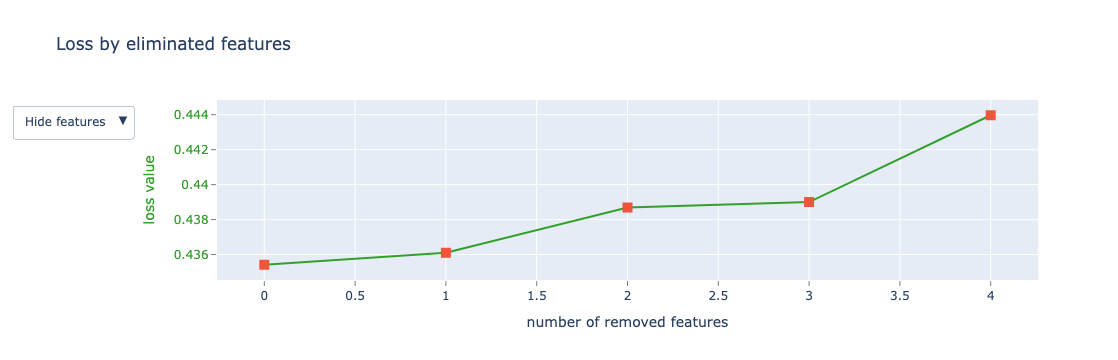

Selected features: ['log_income', 'log_loan_amount', 'log_loan_to_income', 'loan_purpose', 'property_type', 'lien_status']


In [154]:
_ = select_features_adult(algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues, steps=5)

In [22]:
feat_shap=['log_income', 'log_loan_amount', 'log_loan_to_income', 'loan_purpose', 'property_type', 'lien_status']

Algorithm: EFeaturesSelectionAlgorithm.RecursiveByLossFunctionChange


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

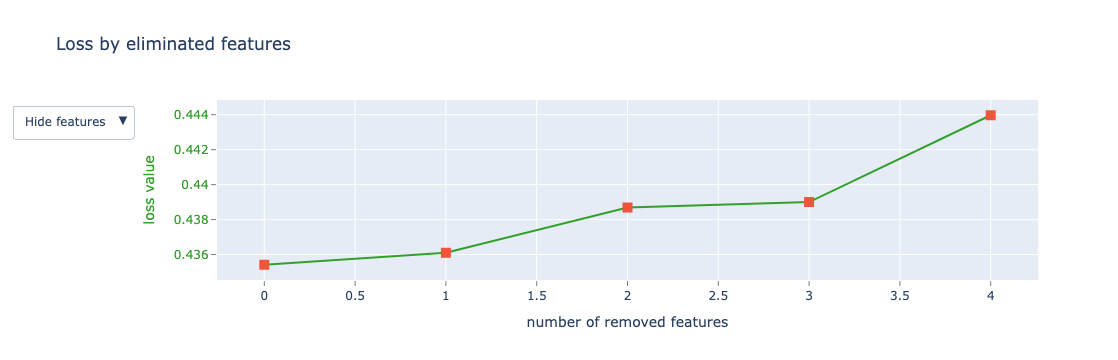

Selected features: ['log_income', 'log_loan_amount', 'log_loan_to_income', 'loan_purpose', 'property_type', 'lien_status']


In [155]:
 _ = select_features_adult(algorithm=EFeaturesSelectionAlgorithm.RecursiveByLossFunctionChange, steps=4)

In [158]:
# feat_loss=

## Modelling

In [163]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train[feat_shap], y_train, test_size=0.2, stratify=y_train, random_state=42)

In [169]:
param_grid = [
    {
        "clf__solver": ["liblinear"],
        "clf__penalty": ["l1", "l2"],
        "clf__C": [0.01, 0.1, 1.0, 10.0],
        "clf__class_weight": [None, "balanced"]
    },
    {
        "clf__solver": ["saga"],
        "clf__penalty": ["l1", "l2"],
        "clf__C": [0.01, 0.1, 1.0, 10.0],
        "clf__class_weight": [None, "balanced"]
    },
    {
        "clf__solver": ["saga"],
        "clf__penalty": ["elasticnet"],
        "clf__l1_ratio": [0.2, 0.5, 0.8],
        "clf__C": [0.01, 0.1, 1.0, 10.0],
        "clf__class_weight": [None, "balanced"]
    }
]

In [190]:
# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# logreg = LogisticRegression(max_iter=5000, random_state=42)

# grid = GridSearchCV(
#     estimator=logreg,
#     param_grid=param_grid,
#     scoring="roc_auc",
#     cv=cv,
#     n_jobs=-1,
#     verbose=1,
#     refit=True
# )

# grid.fit(X_tr, y_tr)

# print("Best ROC-AUC (CV):", grid.best_score_)
# print("Best params:", grid.best_params_)


In [340]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

final_feats = [
    'log_income','log_loan_amount','log_loan_to_income',
    'loan_purpose','property_type','lien_status'
]

Xtr = X_train[final_feats].copy()
Xte = X_test[final_feats].copy()

# categorical -> string
for c in ['loan_purpose','property_type','lien_status']:
    Xtr[c] = Xtr[c].astype(str)
    Xte[c] = Xte[c].astype(str)

# create dummies
Xtr = pd.get_dummies(
    Xtr, columns=['loan_purpose','property_type','lien_status'], drop_first=True
)
Xte = pd.get_dummies(
    Xte, columns=['loan_purpose','property_type','lien_status'], drop_first=True
)

bool_cols = Xtr.select_dtypes(include='bool').columns
Xtr[bool_cols] = Xtr[bool_cols].astype(int)
Xte[bool_cols] = Xte[bool_cols].astype(int)
# align dummy columns
Xte = Xte.reindex(columns=Xtr.columns, fill_value=0)

# -------------------------
# ✅ Add scaling (only numeric)
# -------------------------
num_cols = ['log_income', 'log_loan_amount', 'log_loan_to_income']

scaler = StandardScaler()
Xtr[num_cols] = scaler.fit_transform(Xtr[num_cols])   # fit on train
Xte[num_cols] = scaler.transform(Xte[num_cols])       # transform test

# fit logistic regression
mod_log = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=5000,class_weight=None)
mod_log.fit(Xtr, y_train)


LogisticRegression(max_iter=5000)

In [264]:
Xtr

log_income  log_loan_amount  log_loan_to_income  loan_purpose_2  \
200431     -0.301098         0.638625            1.080966               0   
544842     -0.236848        -0.204793           -0.234669               0   
5081757    -1.217904        -0.429628            0.405034               0   
2439558     0.923560         0.950355            0.255494               1   
9339090     0.383695         0.256736           -0.190149               0   
...              ...              ...                 ...             ...   
7353427    -0.854662        -0.459189           -0.002423               0   
13371685   -1.540429        -0.479398            0.675195               0   
9053578    -0.822895        -0.860687           -0.548550               0   
1953008     0.969742         0.916037            0.160602               0   
13916709   -1.489709        -0.459189            0.651075               0   

          loan_purpose_3  property_type_2  property_type_3  lien_status_2  \
200431                 0                0                0              0   
544842                 0                0                0              0   
5081757                0                0                0              0   
2439558                0                0                0              0   
9339090                1                0                0              0   
...                  ...              ...              ...            ...   
7353427                0                0                0              0   
13371685               0                1                0              0   
9053578                1                0                0              0   
1953008                0                0                0              0   
13916709               1                0                0              0   

          lien_status_3  
200431                0  
544842                0  
5081757               0  
2439558               0  
9339090               0  
...                 ...  
7353427               0  
13371685              0  
9053578               0  
1953008               0  
13916709              0  

[6831017 rows x 9 columns]

In [266]:
pvalue,SE=logit_pvalue(mod_log, Xtr)
# var_name=X_train.iloc[:,6:].columns.tolist()
# var_name.insert(0,'Intercept')
pvalue_table(pvalue,SE,Xtr,mod_log)

Coefficient  Standard_Error  pValue
Intercept              2.081930        0.001771     0.0
log_income             0.106910        0.003000     0.0
log_loan_amount        0.399487        0.004083     0.0
log_loan_to_income    -0.372426        0.003367     0.0
loan_purpose_2        -1.045286        0.004362     0.0
loan_purpose_3        -0.996208        0.002226     0.0
property_type_2       -1.729675        0.004466     0.0
property_type_3        1.424496        0.021507     0.0
lien_status_2         -0.153568        0.005995     0.0
lien_status_3         -0.545787        0.007331     0.0

In [341]:
# data=X_train[feat_shap] 
data=Xtr
y_true=y_train
y_pred=mod_log.predict(data)
# y_pred=model1.predict(X_test.iloc[:,6:])
# y_pred=Xtrain_pred
y_prob=mod_log.predict_proba(data)[:,1]
performance1(y_true,y_pred,y_prob)

Metric
ROC_AUC                                                 0.7158
Ginni                                                     0.43
KS                                                        31.9
Lift                                                      1.16
Brier_Score_Loss                                          0.15
Log_Loss                                                  7.17
Avg Actual Probability       [56.62, 76.1, 83.09, 89.42, 91.8]
Avg Predicted Probability  [58.54, 75.14, 82.82, 88.23, 92.29]

In [276]:
ks1(y_train,y_prob)

KS is 31.900000000000002% at decile 6


min_prob  max_prob    events  nonevents event_rate nonevent_rate  \
Decile                                                                     
1       0.919638  0.998601  628591.0    54511.0     11.59%     3.874767%   
2       0.900191  0.919638  625588.0    57514.0     11.53%     4.088227%   
3       0.883034  0.900191  615876.0    67225.0     11.35%     4.778508%   
4       0.861530  0.883034  605821.0    77281.0     11.17%     5.493311%   
5       0.830136  0.861530  584509.0    98592.0     10.78%     7.008146%   
6       0.787997  0.830136  550651.0   132451.0     10.15%     9.414922%   
7       0.752787  0.787997  529563.0   153539.0      9.76%    10.913905%   
8       0.711893  0.752787  510111.0   172990.0      9.40%    12.296527%   
9       0.625220  0.711893  447445.0   235657.0      8.25%    16.751041%   
10      0.013695  0.625220  326042.0   357060.0      6.01%    25.380646%   

       cum_eventrate cum_noneventrate    KS   bad_rate  Lift  
Decile                                                        
1             11.59%            3.87%   7.7  92.020079  1.16  
2             23.12%            7.96%  15.2  91.580467  1.15  
3             34.48%           12.74%  21.7  90.158849  1.14  
4             45.65%           18.23%  27.4  88.686755  1.12  
5             56.42%           25.24%  31.2  85.566995  1.08  
6             66.57%           34.66%  31.9  80.610363  1.02  
7             76.34%           45.57%  30.8  77.523269  0.98  
8             85.74%           57.87%  27.9  74.675780  0.94  
9             93.99%           74.62%  19.4  65.501931  0.82  
10           100.00%          100.00%   0.0  47.729622  0.60

In [342]:
# data=X_test[feat_shap] 
data=Xte
y_true_test=y_test
y_pred_test=mod_log.predict(data)
# y_pred=model1.predict(X_test.iloc[:,6:])
# y_pred=Xtrain_pred
y_prob_test=mod_log.predict_proba(data)[:,1]
performance1(y_true_test,y_pred_test,y_prob_test)

Metric
ROC_AUC                                                 0.7157
Ginni                                                     0.43
KS                                                        31.9
Lift                                                      1.16
Brier_Score_Loss                                          0.15
Log_Loss                                                  7.17
Avg Actual Probability      [56.65, 76.04, 83.11, 89.42, 91.8]
Avg Predicted Probability  [58.53, 75.14, 82.83, 88.23, 92.29]

In [278]:
ks1(y_test,y_prob_test)

KS is 31.900000000000002% at decile 6


min_prob  max_prob    events  nonevents event_rate nonevent_rate  \
Decile                                                                     
1       0.919706  0.998265  269418.0    23340.0     11.59%     3.871141%   
2       0.900228  0.919706  268106.0    24652.0     11.53%     4.088748%   
3       0.883033  0.900228  263965.0    28793.0     11.36%     4.775568%   
4       0.861563  0.883033  259621.0    33137.0     11.17%     5.496058%   
5       0.830359  0.861563  250476.0    42282.0     10.77%     7.012836%   
6       0.788164  0.830359  236155.0    56603.0     10.16%     9.388098%   
7       0.752787  0.788164  226684.0    66074.0      9.75%    10.958945%   
8       0.711813  0.752787  218561.0    74197.0      9.40%    12.306215%   
9       0.625053  0.711813  191908.0   100850.0      8.26%    16.726846%   
10      0.015112  0.625053  139763.0   152995.0      6.01%    25.375545%   

       cum_eventrate cum_noneventrate    KS   bad_rate  Lift  
Decile                                                        
1             11.59%            3.87%   7.7  92.027545  1.16  
2             23.12%            7.96%  15.2  91.579393  1.15  
3             34.48%           12.74%  21.7  90.164914  1.14  
4             45.65%           18.23%  27.4  88.681095  1.12  
5             56.42%           25.24%  31.2  85.557355  1.08  
6             66.58%           34.63%  31.9  80.665601  1.02  
7             76.33%           45.59%  30.7  77.430506  0.98  
8             85.73%           57.90%  27.8  74.655859  0.94  
9             93.99%           74.62%  19.4  65.551753  0.83  
10           100.00%          100.00%   0.0  47.740113  0.60

#### XGBoost

In [281]:
import optuna


import xgboost as xgb
# Create a validation split from X_train
X_tr, X_val, y_tr, y_val = train_test_split(X_train[feat_shap], y_train, test_size=0.2, stratify=y_train, random_state=42)

# Define the objective function
def objective(trial):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'booster': 'gbtree',
        'tree_method': 'hist',
        'use_label_encoder': False,
        'lambda': trial.suggest_float('lambda', 1e-3, 10.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-3, 10.0, log=True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        # 'random_state':42
        # 'eval_metric': 'AUC',
        'verbose': 0,
        'random_seed': 42
    }

    model = xgb.XGBClassifier(**params,)
    model.fit(
    X_tr,
    y_tr,
    # eval_set=[(X_val, y_val)],
    # eval_metric='auc',
    verbose=False
)


    preds = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, preds)
    return auc

# Run the Optuna study
sampler = optuna.samplers.TPESampler(seed=42)  # Set seed for reproducibility
study_xgb = optuna.create_study(direction="maximize", sampler=sampler)
# study = optuna.create_study(direction='maximize')
study_xgb.optimize(objective, n_trials=30)

# Print the best results
print("✅ Best ROC AUC:", study_xgb.best_value)
print("📌 Best Hyperparameters:")
for k, v in study_xgb.best_params.items():
    print(f"  {k}: {v}")


[I 2026-02-01 11:31:56,062] A new study created in memory with name: no-name-b50c6b5f-d89f-48f4-98ec-5afe251de9f4
[I 2026-02-01 11:32:01,573] Trial 0 finished with value: 0.7281641265879117 and parameters: {'lambda': 0.03148911647956861, 'alpha': 6.3512210106407005, 'colsample_bytree': 0.8659969709057025, 'subsample': 0.7993292420985183, 'learning_rate': 0.01700037298921102, 'max_depth': 4, 'n_estimators': 111, 'min_child_weight': 9}. Best is trial 0 with value: 0.7281641265879117.
[I 2026-02-01 11:32:08,032] Trial 1 finished with value: 0.7326763635497197 and parameters: {'lambda': 0.25378155082656645, 'alpha': 0.6796578090758157, 'colsample_bytree': 0.5102922471479012, 'subsample': 0.9849549260809971, 'learning_rate': 0.1696753360719655, 'max_depth': 4, 'n_estimators': 136, 'min_child_weight': 2}. Best is trial 1 with value: 0.7326763635497197.
[I 2026-02-01 11:32:16,104] Trial 2 finished with value: 0.7322480407393868 and parameters: {'lambda': 0.016480446427978974, 'alpha': 0.12561

✅ Best ROC AUC: 0.7347638217420067
📌 Best Hyperparameters:
  lambda: 0.17658377966548164
  alpha: 0.2971498093583809
  colsample_bytree: 0.8340210512982265
  subsample: 0.9267472351935271
  learning_rate: 0.10139476965979809
  max_depth: 9
  n_estimators: 207
  min_child_weight: 9


In [283]:
model_xgb = xgb.XGBClassifier(**study_xgb.best_params, random_state=42, use_label_encoder=False, eval_metric='auc')
model_xgb.fit(X_train[feat_shap], y_train)

XGBClassifier(alpha=0.2971498093583809, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8340210512982265, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=0.17658377966548164,
              learning_rate=0.10139476965979809, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=9, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=207, n_jobs=None, ...)

In [285]:
data_train_xgb=X_train[feat_shap]
# y_train=y_train.iloc[:,-1]
y_prob_train_xgb=model_xgb.predict_proba(data_train_xgb)[:,1]
y_pred_train_xgb=model_xgb.predict(data_train_xgb)
performance1(y_train,y_pred_train_xgb,y_prob_train_xgb)

Metric
ROC_AUC                                                 0.7378
Ginni                                                     0.48
KS                                                        34.9
Lift                                                      1.17
Brier_Score_Loss                                          0.14
Log_Loss                                                  6.77
Avg Actual Probability     [54.35, 75.93, 83.86, 89.89, 92.99]
Avg Predicted Probability  [54.72, 76.09, 83.48, 89.96, 92.78]

In [314]:
ks1(y_train,y_prob_train_xgb)

KS is 34.9% at decile 6


min_prob  max_prob    events  nonevents event_rate nonevent_rate  \
Decile                                                                     
1       0.927256  0.986897  640490.0    42612.0     11.81%     3.028959%   
2       0.915154  0.927256  629972.0    53130.0     11.61%     3.776603%   
3       0.901153  0.915154  620300.0    62801.0     11.44%     4.464039%   
4       0.876456  0.901153  607844.0    75258.0     11.21%     5.349512%   
5       0.831924  0.876456  585187.0    97914.0     10.79%     6.959952%   
6       0.802491  0.831924  560494.0   122608.0     10.33%     8.715259%   
7       0.764030  0.802491  535347.0   147755.0      9.87%    10.502765%   
8       0.705857  0.764030  501971.0   181130.0      9.25%    12.875137%   
9       0.596710  0.705857  449067.0   234035.0      8.28%    16.635746%   
10      0.003976  0.596710  293525.0   389577.0      5.41%    27.692029%   

       cum_eventrate cum_noneventrate    KS   bad_rate  Lift  
Decile                                                        
1             11.81%            3.03%   8.8  93.761986  1.18  
2             23.42%            6.81%  16.6  92.222245  1.16  
3             34.86%           11.27%  23.6  90.806484  1.14  
4             46.06%           16.62%  29.4  88.982904  1.12  
5             56.85%           23.58%  33.3  85.666248  1.08  
6             67.19%           32.29%  34.9  82.051290  1.03  
7             77.06%           42.80%  34.3  78.369995  0.99  
8             86.31%           55.67%  30.6  73.484155  0.93  
9             94.59%           72.31%  22.3  65.739377  0.83  
10           100.00%          100.00%   0.0  42.969425  0.54

In [286]:
data_test_xgb=X_test[feat_shap]
y_prob_test_xgb=model_xgb.predict_proba(data_test_xgb)[:,1]
y_pred_test_xgb=model_xgb.predict(data_test_xgb)
performance1(y_test,y_pred_test_xgb,y_prob_test_xgb)

Metric
ROC_AUC                                                0.7344
Ginni                                                    0.47
KS                                                       34.4
Lift                                                     1.17
Brier_Score_Loss                                         0.14
Log_Loss                                                  6.8
Avg Actual Probability     [54.72, 75.99, 83.6, 89.98, 92.72]
Avg Predicted Probability   [54.72, 76.1, 83.5, 89.97, 92.78]

In [316]:
ks1(y_test,y_prob_test_xgb)

KS is 34.4% at decile 6


min_prob  max_prob    events  nonevents event_rate nonevent_rate  \
Decile                                                                     
1       0.927270  0.985047  273378.0    19380.0     11.76%     3.214341%   
2       0.915177  0.927270  269524.0    23234.0     11.59%     3.853560%   
3       0.901191  0.915177  265878.0    26880.0     11.44%     4.458281%   
4       0.876635  0.901191  260997.0    31761.0     11.23%     5.267837%   
5       0.832091  0.876633  249800.0    42958.0     10.75%     7.124956%   
6       0.802573  0.832091  239711.0    53047.0     10.31%     8.798304%   
7       0.764174  0.802573  229702.0    63056.0      9.88%    10.458384%   
8       0.705924  0.764174  215244.0    77514.0      9.26%    12.856368%   
9       0.596787  0.705923  193265.0    99493.0      8.31%    16.501776%   
10      0.003976  0.596787  127158.0   165600.0      5.47%    27.466194%   

       cum_eventrate cum_noneventrate    KS   bad_rate  Lift  
Decile                                                        
1             11.76%            3.21%   8.5  93.380198  1.18  
2             23.35%            7.07%  16.3  92.063752  1.16  
3             34.79%           11.53%  23.3  90.818355  1.14  
4             46.02%           16.79%  29.2  89.151108  1.12  
5             56.76%           23.92%  32.8  85.326447  1.07  
6             67.08%           32.72%  34.4  81.880256  1.03  
7             76.96%           43.18%  33.8  78.461391  0.99  
8             86.22%           56.03%  30.2  73.522841  0.93  
9             94.53%           72.53%  22.0  66.015275  0.83  
10           100.00%          100.00%   0.0  43.434509  0.55

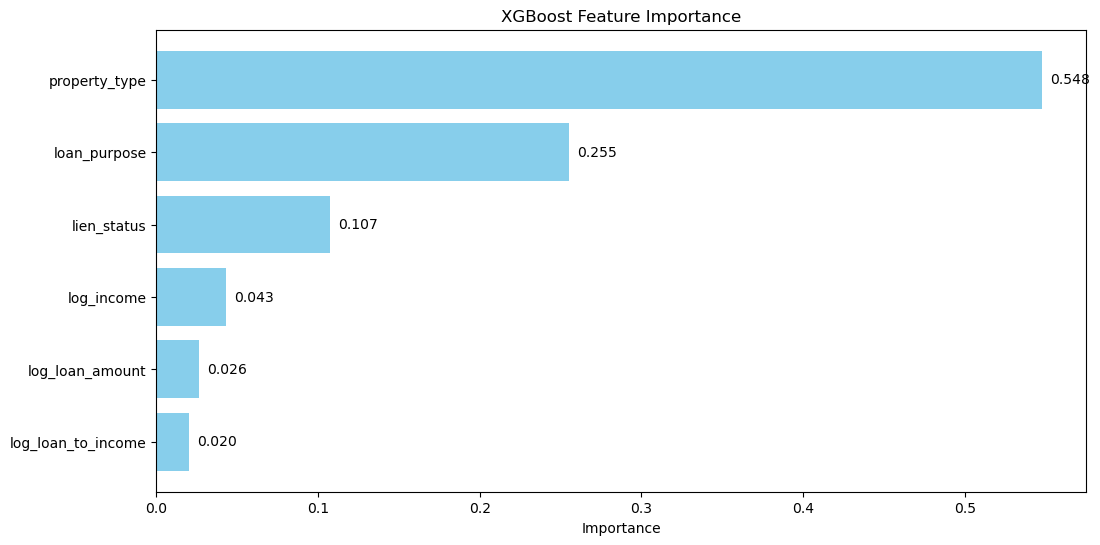

In [289]:
#  Get feature importance
feature_importance = model_xgb.feature_importances_

# Create a DataFrame for feature importance
feature_importance_df = pd.DataFrame({
    'Feature': X_train[feat_shap].columns,
    'Importance': feature_importance
})

# Sort features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)


# Plot feature importance with annotations
plt.figure(figsize=(12, 6))
bars = plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('XGBoost Feature Importance')

# Add annotations with importance scores
for bar, importance in zip(bars, feature_importance_df['Importance']):
    plt.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2, f'{importance:.3f}', 
             va='center', ha='left', fontsize=10)

plt.gca().invert_yaxis()  # Invert y-axis to display highest importance at the top
plt.show()

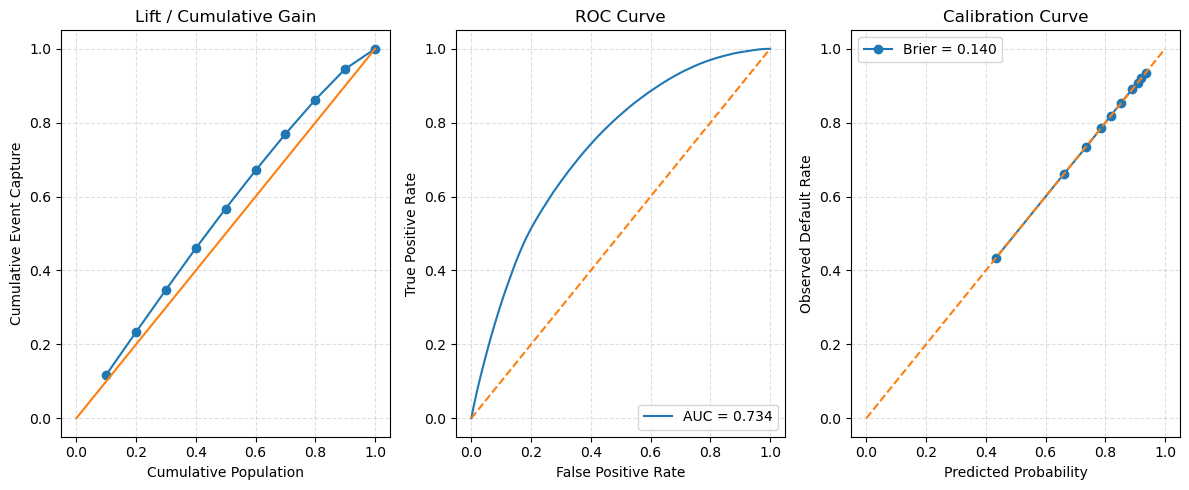

In [299]:
# ---------- 1) LIFT CHART (deciles) ----------
def lift_table(y_true, y_prob, n_bins=10):
    df = pd.DataFrame({"y": y_true, "p": y_prob}).sort_values("p", ascending=False)
    df["bin"] = pd.qcut(df["p"].rank(method="first"), q=n_bins, labels=False)
    # bin 0 = highest scores; flip index so bin 1 = top decile
    df["bin"] = n_bins - df["bin"]
    agg = df.groupby("bin").agg(events=("y", "sum"), total=("y", "count")).sort_index()
    agg["rate"] = agg["events"] / agg["total"]
    overall_rate = df["y"].mean()
    agg["lift"] = agg["rate"] / overall_rate
    agg["cum_events"] = agg["events"].cumsum()
    agg["cum_capture"] = agg["cum_events"] / agg["events"].sum()
    agg["cum_population"] = agg["total"].cumsum() / agg["total"].sum()
    return agg, overall_rate


y_true=y_test
y_prob=y_prob_test_xgb
lift_df, base_rate = lift_table(y_true, y_prob, n_bins=10)

# ---------- 2) ROC / AUC ----------
fpr, tpr, _ = roc_curve(y_true, y_prob)
auc = roc_auc_score(y_true, y_prob)

# ---------- 3) CALIBRATION (reliability curve) ----------
# bins=10–20 are typical; n_bins=10 matches deciles
prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=10, strategy="quantile")
brier = brier_score_loss(y_true, y_prob)

# ---------- PLOT: 3 PANELS ----------
fig, axes = plt.subplots(1, 3, figsize=(12, 5))

# (1) Lift chart
axes[0].plot(lift_df["cum_population"], lift_df["cum_capture"], marker="o")
axes[0].plot([0, 1], [0, 1])  # baseline
axes[0].set_title("Lift / Cumulative Gain")
axes[0].set_xlabel("Cumulative Population")
axes[0].set_ylabel("Cumulative Event Capture")
axes[0].grid(True, linestyle="--", alpha=0.4)

# Optional: show decile lift as bars (comment out if you only want gains curve)
# axes[0].bar(lift_df.index, lift_df["lift"], width=0.8)
# axes[0].set_xticks(lift_df.index)
# axes[0].set_xlabel("Decile (1=best)")
# axes[0].set_ylabel("Lift vs Base")

# (2) ROC
axes[1].plot(fpr, tpr, label=f"AUC = {auc:.3f}")
axes[1].plot([0, 1], [0, 1], linestyle="--")
axes[1].set_title("ROC Curve")
axes[1].set_xlabel("False Positive Rate")
axes[1].set_ylabel("True Positive Rate")
axes[1].legend(loc="lower right")
axes[1].grid(True, linestyle="--", alpha=0.4)

# (3) Calibration
axes[2].plot(prob_pred, prob_true, marker="o", label=f"Brier = {brier:.3f}")
axes[2].plot([0, 1], [0, 1], linestyle="--")
axes[2].set_title("Calibration Curve")
axes[2].set_xlabel("Predicted Probability")
axes[2].set_ylabel("Observed Default Rate")
axes[2].legend(loc="upper left")
axes[2].grid(True, linestyle="--", alpha=0.4)

# plt.title ("XGBoost Model")
plt.tight_layout()
plt.show()

#### Catboost

In [302]:
# Create a validation split from X_train
X_tr, X_val, y_tr, y_val = train_test_split(X_train[feat_shap], y_train, test_size=0.2, stratify=y_train, random_state=42)

# Define the objective function for Optuna
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 300),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10.0, log=True),
        'bootstrap_type': trial.suggest_categorical('bootstrap_type', ['Bayesian', 'Bernoulli', 'MVS']),
        'random_strength': trial.suggest_float('random_strength', 1e-3, 10.0, log=True),
        'eval_metric': 'AUC',
        'verbose': 0,
        'random_seed': 42
    }

    if params['bootstrap_type'] == 'Bayesian':
        params['bagging_temperature'] = trial.suggest_float('bagging_temperature', 0, 10)

    train_pool = Pool(X_tr, y_tr)
    val_pool = Pool(X_val, y_val)

    model = CatBoostClassifier(**params)
    model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=30)

    preds = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, preds)
    return auc

# Run the Optuna study
sampler = optuna.samplers.TPESampler(seed=42)  # Set seed for reproducibility
study_cat = optuna.create_study(direction="maximize", sampler=sampler)
# study = optuna.create_study(direction='maximize')
study_cat.optimize(objective, n_trials=50)

# Print best results
print("✅ Best ROC AUC:", study_cat.best_value)
print("📌 Best Hyperparameters:")
for k, v in study_cat.best_params.items():
    print(f"  {k}: {v}")


[I 2026-02-01 11:53:53,136] A new study created in memory with name: no-name-475abb3a-74dd-4d7a-b64e-8005983cd846
[I 2026-02-01 11:54:20,231] Trial 0 finished with value: 0.7319000008349503 and parameters: {'iterations': 175, 'depth': 10, 'learning_rate': 0.1205712628744377, 'l2_leaf_reg': 0.24810409748678114, 'bootstrap_type': 'Bayesian', 'random_strength': 2.915443189153755, 'bagging_temperature': 6.011150117432088}. Best is trial 0 with value: 0.7319000008349503.
[I 2026-02-01 11:54:45,424] Trial 1 finished with value: 0.7310202774502481 and parameters: {'iterations': 242, 'depth': 4, 'learning_rate': 0.27081608642499677, 'l2_leaf_reg': 2.136832907235876, 'bootstrap_type': 'Bayesian', 'random_strength': 0.016480446427978974, 'bagging_temperature': 5.247564316322379}. Best is trial 0 with value: 0.7319000008349503.
[I 2026-02-01 11:55:00,481] Trial 2 finished with value: 0.732191354673126 and parameters: {'iterations': 186, 'depth': 6, 'learning_rate': 0.08012737503998542, 'l2_leaf_r

✅ Best ROC AUC: 0.7351300139566966
📌 Best Hyperparameters:
  iterations: 284
  depth: 9
  learning_rate: 0.26059210429243124
  l2_leaf_reg: 0.18886689115801067
  bootstrap_type: MVS
  random_strength: 2.7707802160803143


In [32]:
catboost_best_params = {
    "iterations": 284,
    "depth": 9,
    "learning_rate": 0.26059210429243124,
    "l2_leaf_reg": 0.18886689115801067,
    "bootstrap_type": "MVS",
    "random_strength": 2.7707802160803143,
    "eval_metric": "AUC",
    "loss_function": "Logloss",
    "random_seed": 42,
    "verbose": False
}
feat_shap=['log_income', 'log_loan_amount', 'log_loan_to_income', 'loan_purpose', 'property_type', 'lien_status']

In [328]:
# cb_shap = CatBoostClassifier(**study_cat.best_params,eval_metric = 'AUC',random_state=42)
# cb_shap.fit(X_train[feat_shap],
#           y_train,
#           verbose = 0,
#           eval_set = (X_test[feat_shap], y_test))

In [34]:
cb_shap = CatBoostClassifier(**catboost_best_params)
cb_shap.fit(X_train[feat_shap],
          y_train,
          verbose = 0,
          eval_set = (X_test[feat_shap], y_test))

In [36]:
# data_train_shap=X_train[feat_shap]
data_train_shap=X_train[feat_shap]
# y_train=y_train.iloc[:,-1]
y_prob_train_shap=cb_shap.predict_proba(data_train_shap)[:,1]
y_pred_train_shap=cb_shap.predict(data_train_shap)
performance1(y_train,y_pred_train_shap,y_prob_train_shap)

Metric
ROC_AUC                                                  0.736
Ginni                                                     0.47
KS                                                        34.6
Lift                                                      1.17
Brier_Score_Loss                                          0.14
Log_Loss                                                  6.78
Avg Actual Probability     [54.49, 76.02, 83.76, 89.98, 92.78]
Avg Predicted Probability  [54.74, 76.07, 83.53, 89.95, 92.74]

In [ ]:
# data_train_shap=X_train[feat_shap]
# # y_train=y_train.iloc[:,-1]
# y_prob_train_shap=cb_shap.predict_proba(data_train_shap)[:,1]
# y_pred_train_shap=cb_shap.predict(data_train_shap)
# performance1(y_train,y_pred_train_shap,y_prob_train_shap)

In [63]:
# data_test_shap=X_test[feat_shap]
data_test_shap=X_test[feat_shap]

y_prob_test_shap=cb_shap.predict_proba(data_test_shap)[:,1]
y_pred_test_shap=cb_shap.predict(data_test_shap)
performance1(y_test,y_pred_test_shap,y_prob_test_shap)


Metric
ROC_AUC                                                 0.7349
Ginni                                                     0.47
KS                                                        34.5
Lift                                                      1.17
Brier_Score_Loss                                          0.14
Log_Loss                                                   6.8
Avg Actual Probability      [54.67, 75.96, 83.7, 89.96, 92.74]
Avg Predicted Probability  [54.74, 76.08, 83.54, 89.95, 92.74]

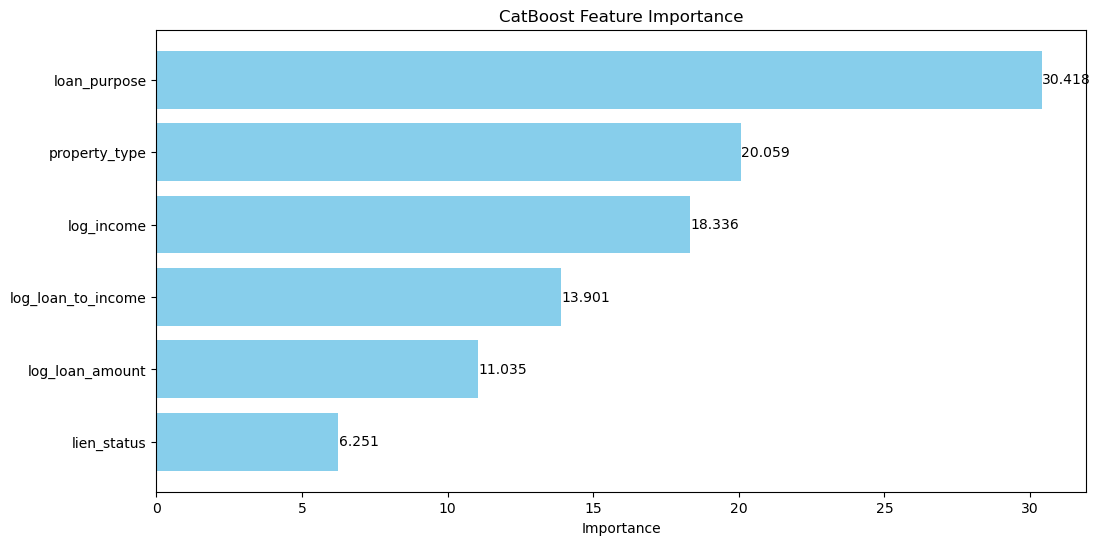

In [306]:
#  Get feature importance
feature_importance = cb_shap.get_feature_importance()

# Create a DataFrame for feature importance
feature_importance_df = pd.DataFrame({
    'Feature': X_train[feat_shap].columns,
    'Importance': feature_importance
})

# Sort features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)


# Plot feature importance with annotations
plt.figure(figsize=(12, 6))
bars = plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('CatBoost Feature Importance')

# Add annotations with importance scores
for bar, importance in zip(bars, feature_importance_df['Importance']):
    plt.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2, f'{importance:.3f}', 
             va='center', ha='left', fontsize=10)

plt.gca().invert_yaxis()  # Invert y-axis to display highest importance at the top
plt.show()

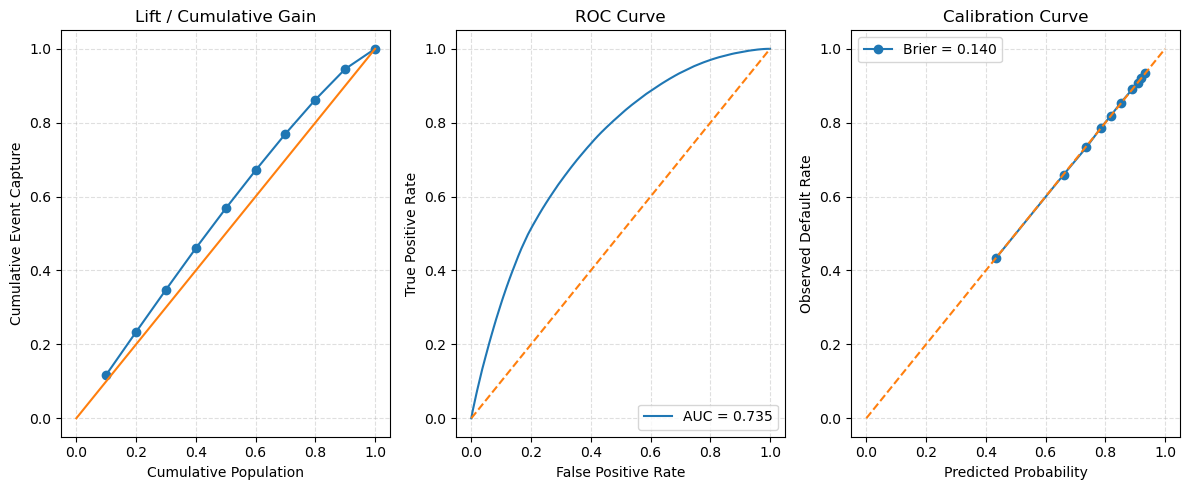

In [307]:
# ---------- 1) LIFT CHART (deciles) ----------
def lift_table(y_true, y_prob, n_bins=10):
    df = pd.DataFrame({"y": y_true, "p": y_prob}).sort_values("p", ascending=False)
    df["bin"] = pd.qcut(df["p"].rank(method="first"), q=n_bins, labels=False)
    # bin 0 = highest scores; flip index so bin 1 = top decile
    df["bin"] = n_bins - df["bin"]
    agg = df.groupby("bin").agg(events=("y", "sum"), total=("y", "count")).sort_index()
    agg["rate"] = agg["events"] / agg["total"]
    overall_rate = df["y"].mean()
    agg["lift"] = agg["rate"] / overall_rate
    agg["cum_events"] = agg["events"].cumsum()
    agg["cum_capture"] = agg["cum_events"] / agg["events"].sum()
    agg["cum_population"] = agg["total"].cumsum() / agg["total"].sum()
    return agg, overall_rate


y_true=y_test
y_prob=y_prob_test_shap
lift_df, base_rate = lift_table(y_true, y_prob, n_bins=10)

# ---------- 2) ROC / AUC ----------
fpr, tpr, _ = roc_curve(y_true, y_prob)
auc = roc_auc_score(y_true, y_prob)

# ---------- 3) CALIBRATION (reliability curve) ----------
# bins=10–20 are typical; n_bins=10 matches deciles
prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=10, strategy="quantile")
brier = brier_score_loss(y_true, y_prob)

# ---------- PLOT: 3 PANELS ----------
fig, axes = plt.subplots(1, 3, figsize=(12, 5))

# (1) Lift chart
axes[0].plot(lift_df["cum_population"], lift_df["cum_capture"], marker="o")
axes[0].plot([0, 1], [0, 1])  # baseline
axes[0].set_title("Lift / Cumulative Gain")
axes[0].set_xlabel("Cumulative Population")
axes[0].set_ylabel("Cumulative Event Capture")
axes[0].grid(True, linestyle="--", alpha=0.4)

# Optional: show decile lift as bars (comment out if you only want gains curve)
# axes[0].bar(lift_df.index, lift_df["lift"], width=0.8)
# axes[0].set_xticks(lift_df.index)
# axes[0].set_xlabel("Decile (1=best)")
# axes[0].set_ylabel("Lift vs Base")

# (2) ROC
axes[1].plot(fpr, tpr, label=f"AUC = {auc:.3f}")
axes[1].plot([0, 1], [0, 1], linestyle="--")
axes[1].set_title("ROC Curve")
axes[1].set_xlabel("False Positive Rate")
axes[1].set_ylabel("True Positive Rate")
axes[1].legend(loc="lower right")
axes[1].grid(True, linestyle="--", alpha=0.4)

# (3) Calibration
axes[2].plot(prob_pred, prob_true, marker="o", label=f"Brier = {brier:.3f}")
axes[2].plot([0, 1], [0, 1], linestyle="--")
axes[2].set_title("Calibration Curve")
axes[2].set_xlabel("Predicted Probability")
axes[2].set_ylabel("Observed Default Rate")
axes[2].legend(loc="upper left")
axes[2].grid(True, linestyle="--", alpha=0.4)

# plt.title ("XGBoost Model")
plt.tight_layout()
plt.show()

## RQ2 

In [38]:
df_RQ2=df.copy()
df_RQ2['Prob']=cb_shap.predict_proba(df_RQ2[feat_shap])[:,1]

In [349]:
df_RQ2.columns

Index(['as_of_year', 'respondent_id', 'agency_name', 'agency_abbr',
       'agency_code', 'loan_type_name', 'loan_type', 'property_type_name',
       'property_type', 'loan_purpose_name', 'loan_purpose',
       'owner_occupancy_name', 'owner_occupancy', 'loan_amount_000s',
       'preapproval_name', 'preapproval', 'action_taken_name', 'action_taken',
       'msamd_name', 'state_name', 'state_abbr', 'state_code', 'county_name',
       'county_code', 'census_tract_number', 'applicant_ethnicity_name',
       'applicant_ethnicity', 'co_applicant_ethnicity_name',
       'co_applicant_ethnicity', 'applicant_race_name_1', 'applicant_race_1',
       'applicant_race_name_2', 'applicant_race_2', 'applicant_race_name_3',
       'applicant_race_3', 'applicant_race_name_4', 'applicant_race_4',
       'applicant_race_name_5', 'applicant_race_5', 'co_applicant_race_name_1',
       'co_applicant_race_1', 'co_applicant_race_name_2',
       'co_applicant_race_2', 'co_applicant_race_name_3',
       'co_a

In [432]:
# df_RQ2['loan_status']=list(np.where(df_RQ2.Prob >=0.50, 1,0))


In [405]:
# df_RQ2.groupby('applicant_race_name_1')['loan_status'].mean() # Of all applicants in each race group, what % were approved

In [407]:
# y_pred_prob = cb_shap.predict_proba(X_test)[:, 1]
# y_pred = (y_pred_prob >= 0.5).astype(int)
# test_eval = df.loc[X_test.index, [
#     'target',
#     'applicant_sex_name',
#     'applicant_ethnicity_name',
#     'applicant_race_name_1'
# ]].copy()

# test_eval['y_pred_prob'] = y_pred_prob
# test_eval['y_pred'] = y_pred


In [434]:
# import numpy as np
# import pandas as pd
# from scipy.stats import chi2_contingency

# def fairness_summary(df_eval, group_col, pred_col='y_pred'):
#     out = df_eval.groupby(group_col)[pred_col].agg(['count','mean']).reset_index()
#     out = out.rename(columns={'mean': 'predicted_approval_rate'})
#     out = out.sort_values('predicted_approval_rate', ascending=False)

#     # Disparate Impact Ratio (DIR)
#     best = out['predicted_approval_rate'].max()
#     out['DIR_vs_best'] = out['predicted_approval_rate'] / best
    
#     return out

# def chi_square_test(df_eval, group_col, pred_col='y_pred'):
#     tab = pd.crosstab(df_eval[group_col], df_eval[pred_col])
#     chi2, p, dof, expected = chi2_contingency(tab)
#     return tab, chi2, p


In [436]:
# race_summary = fairness_summary(test_eval, 'applicant_race_name_1')
# race_summary

In [438]:
# race_tab, race_chi2, race_p = chi_square_test(test_eval, 'applicant_race_name_1')
# print(race_tab)
# print("Chi-square p-value:", race_p)

In [440]:
# sex_summary = fairness_summary(test_eval, 'applicant_sex_name')
# display(sex_summary)
# sex_tab, sex_chi2, sex_p = chi_square_test(test_eval, 'applicant_sex_name')
# display(sex_tab)
# print("Chi-square p-value:", sex_p)


In [442]:
# grp = df_RQ2.groupby('applicant_race_name_1').agg(
#     actual_rate=('target','mean'),
#     predicted_prob=('Prob','mean'),
#     n=('target','size')
# )

# grp['gap_pred_minus_actual'] = grp['predicted_prob'] - grp['actual_rate']
# grp.sort_values('predicted_prob', ascending=False)


In [419]:
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency

def fairness_audit(
    df_eval: pd.DataFrame,
    group_col: str,
    target_col: str = "target",
    prob_col: str = "Prob",
    threshold: float = 0.5,
    min_group_n: int = 200,
    dropna: bool = True
):
    """
    Fairness audit for a protected attribute column.

    Returns:
      summary_df: group-level table with actual/predicted rates, DIR, gaps, etc.
      stats: dict with chi-square p-value and contingency table
    """

    d = df_eval[[group_col, target_col, prob_col]].copy()

    # Basic cleaning
    if dropna:
        d = d.dropna(subset=[group_col, target_col, prob_col])
    else:
        d[group_col] = d[group_col].fillna("Missing")

    # Ensure binary ints
    d[target_col] = d[target_col].astype(int)

    # Predicted label at a chosen threshold
    d["pred_label"] = (d[prob_col] >= threshold).astype(int)

    # Group-level metrics
    summary = d.groupby(group_col).agg(
        n=(target_col, "size"),
        actual_rate=(target_col, "mean"),
        avg_pred_prob=(prob_col, "mean"),
        pred_rate=("pred_label", "mean")
    ).reset_index()

    # Filter tiny groups (optional but recommended for stability)
    summary["kept"] = summary["n"] >= min_group_n
    summary_kept = summary[summary["kept"]].copy()

    # DIR (vs group with max predicted approval rate)
    if len(summary_kept) > 0:
        best = summary_kept["pred_rate"].max()
        summary_kept["DIR_vs_best"] = np.where(best > 0, summary_kept["pred_rate"] / best, np.nan)
    else:
        summary_kept["DIR_vs_best"] = np.nan

    # Gap: predicted probability minus actual approval rate
    summary_kept["gap_prob_minus_actual"] = summary_kept["avg_pred_prob"] - summary_kept["actual_rate"]

    # Chi-square test on predicted approvals (kept groups only)
    stats = {"chi2_p_value": np.nan, "contingency": None, "note": ""}

    if len(summary_kept) >= 2:
        d_kept = d[d[group_col].isin(summary_kept[group_col])]
        tab = pd.crosstab(d_kept[group_col], d_kept["pred_label"])

        # Need both 0 and 1 columns present
        if tab.shape[1] == 2:
            chi2, p, dof, exp = chi2_contingency(tab)
            stats["chi2_p_value"] = p
            stats["contingency"] = tab
        else:
            stats["note"] = "Chi-square not computed: only one class present in pred_label."
            stats["contingency"] = tab
    else:
        stats["note"] = "Chi-square not computed: <2 groups after min_group_n filtering."

    # Sort for readability
    summary_kept = summary_kept.sort_values("avg_pred_prob", ascending=False)

    return summary_kept, stats


In [423]:
protected_cols = [
    "applicant_race_name_1",
    "applicant_sex_name",
    "applicant_ethnicity_name"
]

results = {}

for col in protected_cols:
    summary, stats = fairness_audit(df_RQ2, group_col=col, threshold=0.5, min_group_n=200)
    results[col] = {"summary": summary, "stats": stats}

    print("\n" + "="*80)
    print(f"FAIRNESS AUDIT FOR: {col}")
    print("="*80)
    display(summary)

    print("\nChi-square p-value:", stats["chi2_p_value"])
    if stats["note"]:
        print("Note:", stats["note"])



FAIRNESS AUDIT FOR: applicant_race_name_1


applicant_race_name_1        n  actual_rate  \
5                                     Not applicable   156020     0.947244   
1                                              Asian   512454     0.830699   
6                                              White  7048794     0.816765   
4          Native Hawaiian or Other Pacific Islander    43242     0.749803   
3  Information not provided by applicant in mail,...  1180539     0.715877   
2                          Black or African American   737457     0.662005   
0                   American Indian or Alaska Native    80091     0.654481   

   avg_pred_prob  pred_rate  kept  DIR_vs_best  gap_prob_minus_actual  
5       0.863153   0.985329  True     1.000000              -0.084091  
1       0.831599   0.962826  True     0.977162               0.000900  
6       0.797230   0.943146  True     0.957189              -0.019535  
4       0.782088   0.926669  True     0.940466               0.032285  
3       0.776395   0.931772  True     0.945646               0.060517  
2       0.758982   0.890116  True     0.903369               0.096977  
0       0.732035   0.861458  True     0.874284               0.077554


Chi-square p-value: 0.0

FAIRNESS AUDIT FOR: applicant_sex_name


applicant_sex_name        n  actual_rate  \
3                                     Not applicable   155965     0.947456   
2                                               Male  6050950     0.809944   
1  Information not provided by applicant in mail,...   706601     0.709328   
0                                             Female  2845081     0.772893   

   avg_pred_prob  pred_rate  kept  DIR_vs_best  gap_prob_minus_actual  
3       0.862619   0.984881  True     1.000000              -0.084837  
2       0.804465   0.949180  True     0.963750              -0.005479  
1       0.778803   0.941325  True     0.955775               0.069475  
0       0.772015   0.913321  True     0.927341              -0.000878


Chi-square p-value: 0.0

FAIRNESS AUDIT FOR: applicant_ethnicity_name


applicant_ethnicity_name        n  actual_rate  \
3                                     Not applicable   159471     0.944034   
2                             Not Hispanic or Latino  7483430     0.809957   
0                                 Hispanic or Latino  1000626     0.744035   
1  Information not provided by applicant in mail,...  1115070     0.710761   

   avg_pred_prob  pred_rate  kept  DIR_vs_best  gap_prob_minus_actual  
3       0.861437   0.984154  True     1.000000              -0.082597  
2       0.798661   0.944568  True     0.959777              -0.011296  
0       0.776181   0.911747  True     0.926428               0.032146  
1       0.769724   0.917237  True     0.932005               0.058963


Chi-square p-value: 0.0


There IS a statistically significant association between race group and predicted approvals.
Predicted approval rates are not the same across racial groups.<br>
Although the chi-square test indicates statistically significant disparities, practical significance was examined using the Disparate Impact Ratio (DIR) and absolute differences in predicted approval rates across demographic groups.<br>
<br>
In addition to approval-rate disparities, group-wise probability calibration was assessed using the difference between average predicted probabilities and observed approval rates (gap_prob_minus_actual). Positive values indicate systematic overestimation of approvals, whereas negative values indicate underestimation for a given demographic group.

Final Conclusion:<br>
The fairness analysis indicates statistically significant differences in predicted approval outcomes across demographic groups (p < 0.001). However, the magnitude of these differences is moderate, as the Disparate Impact Ratios (DIR) across protected groups remain above the 0.80 adverse-impact threshold, suggesting no severe disparate impact under the 80% ru

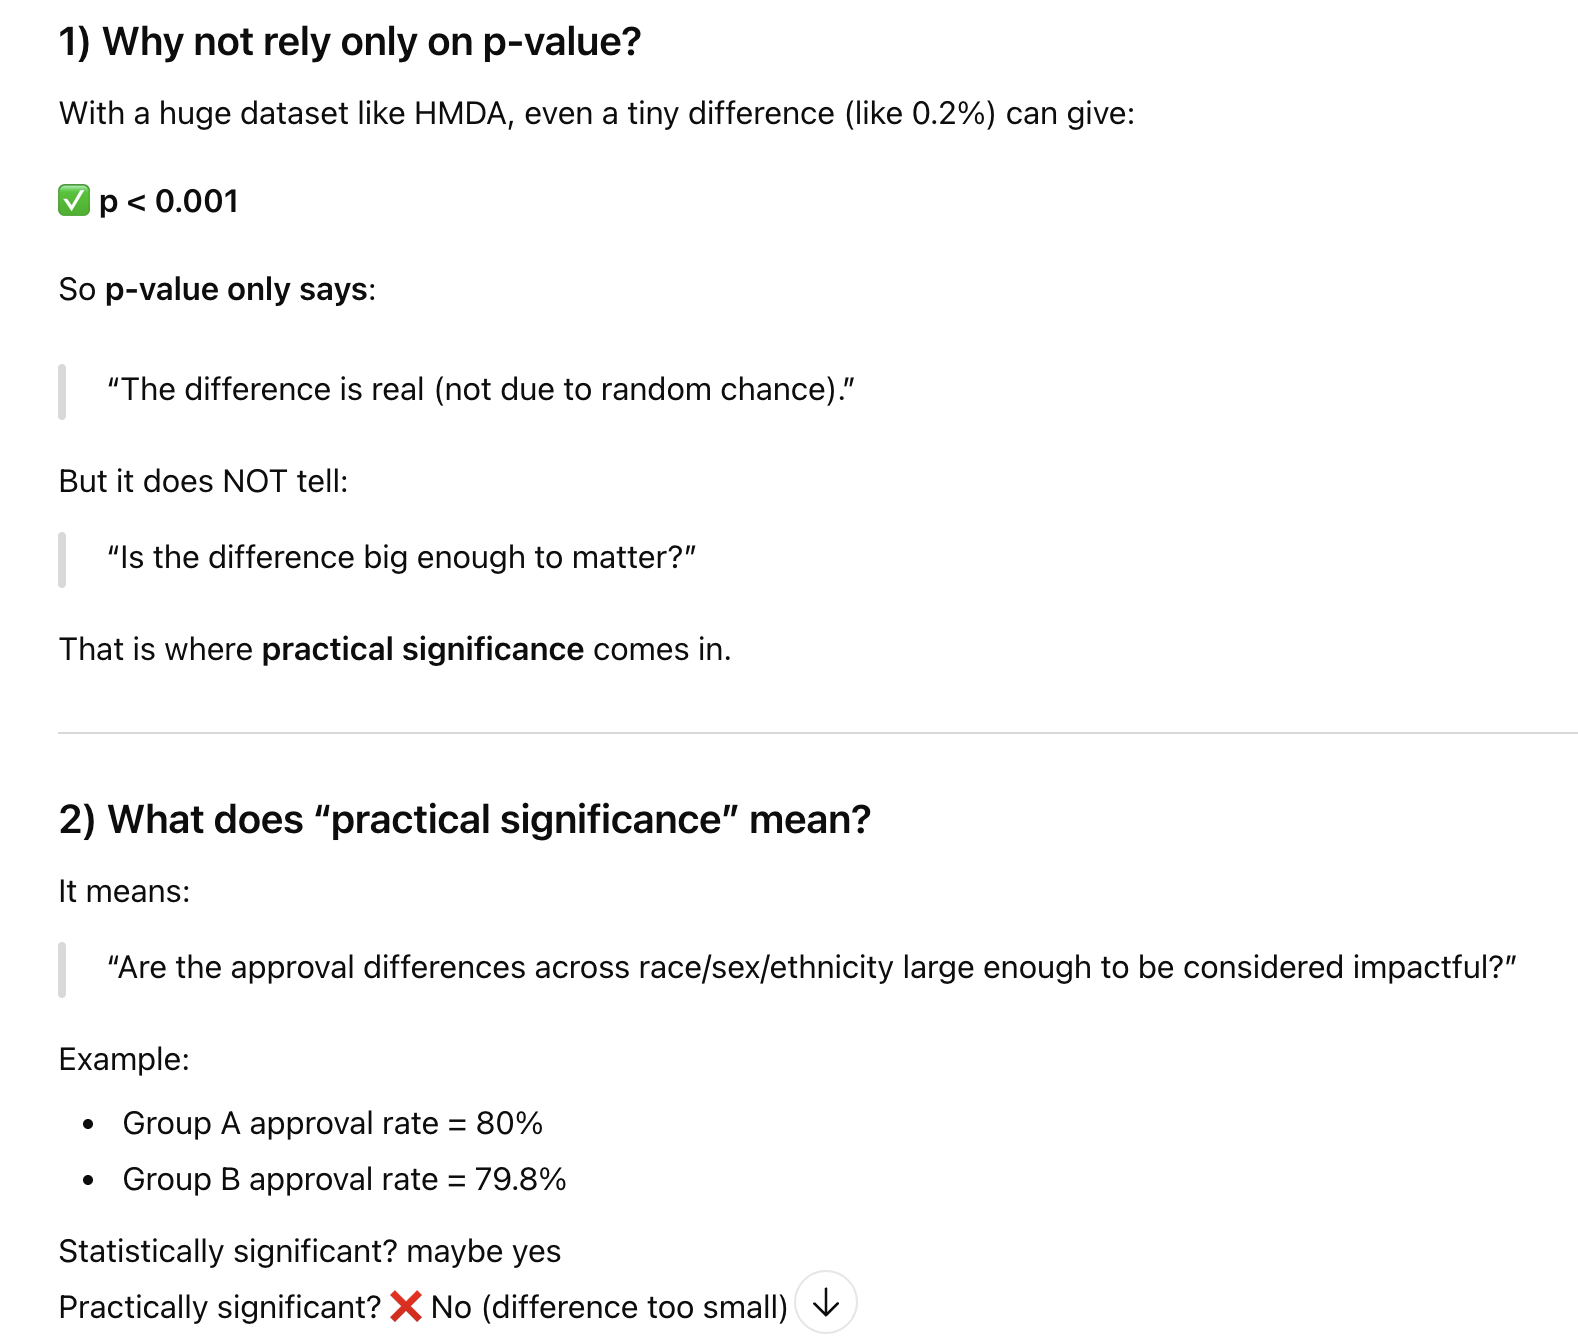

## RQ3

Reasearch Questions : Are there statistically significant differences in model error rates across demographic groups? <br>

Null hypothesis (H₀): The distribution of model errors (TP vs FN) is independent of race.<br>

Hypothesis (H3) :Model error rates (e.g., TPR, FNR) differ significantly across demographic groups.

In [48]:
df_RQ3=df.copy()
df_RQ3['Prob']=cb_shap.predict_proba(df_RQ3[feat_shap])[:,1]

In [50]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from scipy.stats import chi2_contingency

# -----------------------------
# Inputs you already have
# -----------------------------
feat_shap = ['log_income', 'log_loan_amount', 'log_loan_to_income',
            'loan_purpose', 'property_type', 'lien_status']

# df must contain: target + protected columns + feat_shap columns
# cb_shap must be your trained CatBoostClassifier
# Choose the same threshold you used in RQ2
THRESH = 0.50

# -----------------------------
# Helper functions
# -----------------------------
def _safe_div(a, b):
    return np.nan if b == 0 else a / b

def compute_group_error_rates(df_in, group_col, y_col='target', prob_col='Prob', thr=0.50,
                              exclude_values=('Not applicable', 'Information not provided by applicant in mail, Internet, or telephone application'),
                              min_n=5000, reference='best_tpr'):
    """
    Returns:
      summary_df: per-group confusion-matrix rates + fairness gaps
      pvals: dict with chi-square p-values for TPR/FNR equality across groups
    """
    df = df_in.copy()

    # Basic cleanup for group column
    df[group_col] = df[group_col].astype(str).fillna("Missing")

    # Exclude nuisance categories if present
    if exclude_values:
        df = df[~df[group_col].isin(exclude_values)].copy()

    # Predicted label using threshold
    df['pred'] = (df[prob_col] >= thr).astype(int)

    # Aggregate confusion matrix by group
    rows = []
    for g, dfg in df.groupby(group_col):
        n = len(dfg)
        if n < min_n:
            continue

        y_true = dfg[y_col].astype(int).values
        y_pred = dfg['pred'].astype(int).values

        # confusion_matrix returns [[TN, FP],[FN, TP]] for labels=[0,1]
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()

        tpr = _safe_div(tp, tp + fn)   # sensitivity / recall for class 1
        fnr = _safe_div(fn, tp + fn)
        fpr = _safe_div(fp, fp + tn)
        tnr = _safe_div(tn, fp + tn)

        rows.append({
            group_col: g,
            "n": n,
            "TP": tp, "FP": fp, "TN": tn, "FN": fn,
            "TPR": tpr,
            "FNR": fnr,
            "FPR": fpr,
            "TNR": tnr,
        })

    summary = pd.DataFrame(rows)
    if summary.empty:
        return summary, {"chi2_tpr_p": np.nan, "chi2_fnr_p": np.nan}

    # Choose reference group for gaps
    if reference == 'best_tpr':
        ref_row = summary.loc[summary["TPR"].idxmax()]
    else:
        # If you pass a specific group name, use it if present else fallback to best_tpr
        if reference in summary[group_col].values:
            ref_row = summary.loc[summary[group_col] == reference].iloc[0]
        else:
            ref_row = summary.loc[summary["TPR"].idxmax()]

    ref_tpr = ref_row["TPR"]
    ref_fnr = ref_row["FNR"]

    # Equal Opportunity Difference (EOD): TPR_group - TPR_ref
    summary["EOD_vs_ref"] = summary["TPR"] - ref_tpr
    summary["FNR_gap_vs_ref"] = summary["FNR"] - ref_fnr
    summary["ref_group"] = ref_row[group_col]

    # -----------------------------
    # Statistical tests (Chi-square)
    # -----------------------------
    # TPR equality: contingency table uses [TP, FN] per group (i.e., among actual positives)
    tpr_table = summary[["TP", "FN"]].to_numpy()
    chi2_tpr, p_tpr, _, _ = chi2_contingency(tpr_table)

    # FPR equality (optional) could use [FP, TN] among actual negatives, but your RQ3 focuses on TPR/FNR.
    # For completeness, we can also test FNR equality which is equivalent to TPR table (same table)—
    # but we keep a second key for reporting symmetry.
    p_fnr = p_tpr

    # Sort nicely (lowest TPR first shows harmed groups at bottom/top depending on taste)
    summary = summary.sort_values("TPR", ascending=False).reset_index(drop=True)

    pvals = {
        "chi2_tpr_p": p_tpr,
        "chi2_fnr_p": p_fnr,
        "ref_group": ref_row[group_col],
        "chi2_stat": chi2_tpr
    }
    return summary, pvals


def run_rq3_audit(df_in, protected_cols, y_col='target', prob_col='Prob', thr=0.50,
                  exclude_values=('Not applicable', 'Information not provided by applicant in mail, Internet, or telephone application'),
                  min_n=5000):
    """
    Runs RQ3 for a list of protected attributes.
    Returns a dict: {protected_col: (summary_df, pvals_dict)}
    """
    results = {}
    for col in protected_cols:
        summ, pvals = compute_group_error_rates(
            df_in, group_col=col, y_col=y_col, prob_col=prob_col, thr=thr,
            exclude_values=exclude_values, min_n=min_n, reference='best_tpr'
        )
        results[col] = (summ, pvals)
    return results

# -----------------------------
# Build df_RQ3 with probabilities
# -----------------------------
df_RQ3 = df.copy()

# If you trained CatBoost with categorical handling, ensure the same feature dtypes are used here.
# Cast categoricals to string (safe for CatBoost; it can handle object/str)
for c in ['loan_purpose', 'property_type', 'lien_status']:
    df_RQ3[c] = df_RQ3[c].astype(str)

# Predicted probability from CatBoost champion model
df_RQ3['Prob'] = cb_shap.predict_proba(df_RQ3[feat_shap])[:, 1]

# -----------------------------
# Run RQ3 for protected attributes
# -----------------------------
protected_cols = [
    "applicant_race_name_1",
    "applicant_sex_name",
    "applicant_ethnicity_name"
]

rq3_results = run_rq3_audit(
    df_RQ3,
    protected_cols=protected_cols,
    y_col="target",
    prob_col="Prob",
    thr=THRESH,
    # Keep same exclusions you used earlier; change if you want
    exclude_values=('Not applicable', 'Information not provided by applicant in mail, Internet, or telephone application'),
    min_n=5000
)

# -----------------------------
# Display results
# -----------------------------
for col, (summ, pvals) in rq3_results.items():
    print("\n" + "="*90)
    print(f"RQ3 ERROR-RATE FAIRNESS AUDIT FOR: {col}")
    print("="*90)
    if summ.empty:
        print("No groups met min_n after exclusions.")
        continue

    # Keep key columns for report
    display_cols = [col, "n", "TPR", "FNR", "FPR", "TNR", "EOD_vs_ref", "FNR_gap_vs_ref"]
    print(summ[display_cols].to_string(index=False))

    print(f"\nReference group (best TPR): {pvals['ref_group']}")
    print(f"Chi-square test (TP vs FN across groups) p-value: {pvals['chi2_tpr_p']:.6g}")



RQ3 ERROR-RATE FAIRNESS AUDIT FOR: applicant_race_name_1
                    applicant_race_name_1       n      TPR      FNR      FPR      TNR  EOD_vs_ref  FNR_gap_vs_ref
                                    Asian  512454 0.983841 0.016159 0.859715 0.140285    0.000000        0.000000
                                    White 7048794 0.972349 0.027651 0.812972 0.187028   -0.011491        0.011491
Native Hawaiian or Other Pacific Islander   43242 0.971348 0.028652 0.792772 0.207228   -0.012493        0.012493
                Black or African American  737457 0.960971 0.039029 0.751337 0.248663   -0.022870        0.022870
         American Indian or Alaska Native   80091 0.946450 0.053550 0.700466 0.299534   -0.037391        0.037391

Reference group (best TPR): Asian
Chi-square test (TP vs FN across groups) p-value: 0

RQ3 ERROR-RATE FAIRNESS AUDIT FOR: applicant_sex_name
applicant_sex_name       n      TPR      FNR      FPR      TNR  EOD_vs_ref  FNR_gap_vs_ref
              Male 605095

<b> RQ3 Conclusion </b>

The error-rate fairness analysis reveals statistically significant disparities in model performance across protected demographic groups. Chi-square tests on true positive and false negative counts reject the null hypothesis of equal error distributions across race, sex, and ethnicity (p < 0.001).

In particular, Black, American Indian or Alaska Native, female, and Hispanic applicants exhibit systematically lower true positive rates and higher false negative rates compared to their respective reference groups. This indicates that, conditional on being eligible, these groups face a higher likelihood of erroneous rejection.

While the absolute magnitude of the error-rate gaps is moderate, the consistency of these patterns across demographic dimensions suggests unequal decision quality, raising concerns related to Equal Opportunity fairness in the deployed credit decision model.

In [54]:
# feat_shap

## RQ4

Train champion model on base features only (already did: CatBoost)

Compute SHAP on that model.

Compare SHAP patterns across demographic groups (race/sex/ethnicity) to identify features whose contributions differ systematically.

Link those features to context variables (minority_population, msamd/is_non_msa, tract income, etc.) using correlation / group-imbalance checks — not for training, only for interpretation.

<b>RQ4 Implementation Plan</b> <br>
A) Global explainability (overall)<br>

Global SHAP feature importance (top drivers overall)
SHAP summary plot (beeswarm)

B) Group-wise explainability (core of RQ4) <br>

For each protected attribute (race / sex / ethnicity):
Compute mean(|SHAP|) per feature by group
Compute SHAP contribution direction per feature by group (mean SHAP sign)
Rank features where “importance gap” is highest across groups

C) Proxy evidence (how you justify “proxy”) <br>

For top suspect features (e.g., log_income, log_loan_to_income, lien_status):
Show that these features are statistically associated with group membership
For numeric: ANOVA / Kruskal + effect size
For categorical: chi-square + Cramér’s V

Optionally show they correlate with context features (minority_population, tract income, etc.)

In RQ4, you are asking: Are some model input features acting as proxies for protected attributes (race, sex, ethnicity)?

You test this in two complementary ways:<br>

Association tests → Are features statistically related to protected groups?<br>
Model explainability (SHAP) → Do those features influence predictions differently across groups? <br>

The code you shared handles (1) association testing, split into:<br>
Categorical features → Chi-square + Cramér’s V <br>
Numeric features → Kruskal–Wallis test

In [62]:
context_features

['is_non_msa',
 'state_code',
 'minority_population',
 'hud_median_family_income',
 'tract_to_msamd_income',
 'population',
 'number_of_owner_occupied_units',
 'number_of_1_to_4_family_units',
 'minority_population_missing',
 'hud_median_family_income_missing',
 'tract_to_msamd_income_missing',
 'number_of_owner_occupied_units_missing',
 'number_of_1_to_4_family_units_missing',
 'census_tract_number_missing']

In [126]:
rq4_features=feat_shap+context_features
cat_cols = ['loan_purpose','property_type','lien_status']

# cat_cols = ['loan_type','loan_purpose','property_type','owner_occupancy','lien_status','preapproval']

In [70]:
X

log_income  log_loan_amount  log_loan_to_income  loan_purpose  ...  \
1           4.110874         5.129899            1.335001             3  ...   
3           3.988984         4.488636            0.978468             3  ...   
6           4.369448         1.791759            0.062132             2  ...   
7           3.951244         5.225747            1.532006             1  ...   
8           5.631212         6.984716            1.585411             1  ...   
...              ...              ...                 ...           ...  ...   
14285491    5.123964         6.725034            1.788761             1  ...   
14285492    5.267858         6.734592            1.677532             1  ...   
14285493    5.170484         6.167516            1.313724             3  ...   
14285494    4.025352         4.955827            1.270781             3  ...   
14285495    4.672829         4.330733            0.535058             2  ...   

          tract_to_msamd_income_missing  \
1                                     0   
3                                     0   
6                                     0   
7                                     0   
8                                     0   
...                                 ...   
14285491                              0   
14285492                              0   
14285493                              0   
14285494                              0   
14285495                              0   

          number_of_owner_occupied_units_missing  \
1                                              0   
3                                              0   
6                                              0   
7                                              0   
8                                              0   
...                                          ...   
14285491                                       0   
14285492                                       0   
14285493                                       0   
14285494                                       0   
14285495                                       0   

          number_of_1_to_4_family_units_missing  census_tract_number_missing  
1                                             0                            0  
3                                             0                            0  
6                                             0                            0  
7                                             0                            0  
8                                             0                            0  
...                                         ...                          ...  
14285491                                      0                            0  
14285492                                      0                            0  
14285493                                      0                            0  
14285494                                      0                            0  
14285495                                      0                            0  

[9758597 rows x 20 columns]

In [112]:
# SHAP values for binary classification:
# CatBoost returns SHAP for both classes; use class 1 (approval) if needed.
X_all = df[feat_shap].copy()
explainer = shap.TreeExplainer(cb_shap)
shap_values = explainer.shap_values(X_all)

# For CatBoost binary: shap_values can be list-like [class0, class1]
if isinstance(shap_values, list):
    shap_1 = shap_values[1]   # contributions toward class=1
else:
    shap_1 = shap_values


In [116]:
global_importance = pd.Series(np.mean(np.abs(shap_1), axis=0), index=feat_shap)\
                        .sort_values(ascending=False)
display(global_importance)

loan_purpose          0.460249
log_income            0.245095
log_loan_amount       0.173025
log_loan_to_income    0.145757
property_type         0.101179
lien_status           0.080976
dtype: float64

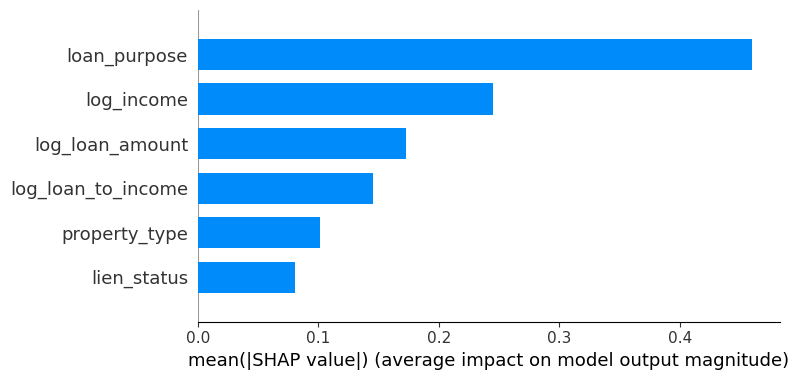

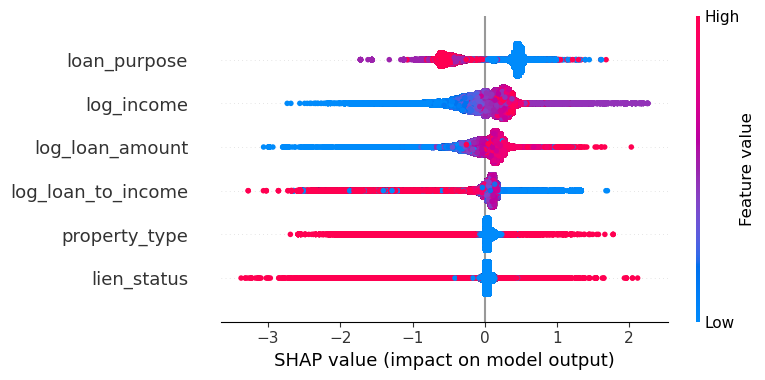

In [118]:
shap.summary_plot(shap_1, X_all, plot_type="bar")
shap.summary_plot(shap_1, X_all)  # beeswarm

### Group-wise SHAP Audit (core RQ4)

#### Function: group-wise SHAP comparison

In [136]:
import numpy as np
import pandas as pd

def rq4_groupwise_shap(df, X_all, shap_1, group_col, drop_values=None, min_n=5000, model=None):
    """
    Group-wise SHAP audit aligned by row-position (safe even if df has non-0..n index).
    """
    # Ensure SAME row order and length as SHAP/X_all
    work = df.loc[X_all.index, [group_col]].copy()
    work["group"] = work[group_col].astype(str)

    if drop_values is not None:
        drop_values = set(map(str, drop_values))
        keep_mask = ~work["group"].isin(drop_values)
        work = work[keep_mask]

    # Use positional indices (0..n-1)
    pos = np.arange(len(X_all))
    pos = pos[ X_all.index.isin(work.index) ]  # positions that correspond to kept rows

    Xg = X_all.loc[work.index]
    Sg = shap_1[pos, :]

    # Optional: predicted probabilities
    if model is not None:
        work["prob"] = model.predict_proba(Xg)[:, 1]
    else:
        work["prob"] = np.nan

    out = []
    # iterate groups using row positions inside `work`
    for g in work["group"].unique():
        g_mask = (work["group"].values == g)
        n = int(g_mask.sum())
        if n < min_n:
            continue

        Ss = Sg[g_mask, :]   # SHAP rows for this group

        row = {"group": g, "n": n}
        if model is not None:
            row["avg_pred_prob"] = float(np.nanmean(work.loc[g_mask, "prob"]))
        else:
            row["avg_pred_prob"] = np.nan

        for j, f in enumerate(X_all.columns):
            row[f"imp_{f}"] = float(np.mean(np.abs(Ss[:, j])))
            row[f"dir_{f}"] = float(np.mean(Ss[:, j]))

        out.append(row)

    res = pd.DataFrame(out).sort_values("n", ascending=False).reset_index(drop=True)
    return res

imp_feature = mean(|SHAP_feature|) >  Feature Importance (Magnitude) <br>
dir_feature = mean(SHAP_feature) > Feature Direction (Bias)

imp_<feature> = Importance<br>
→ How strongly this feature influences the model’s predictions for a specific group<br>
→ Computed as mean absolute SHAP value

dir_<feature> = Direction<br>
→ Which way the feature pushes decisions on average for that group<br>
→ Computed as mean signed SHAP value

Feature importance (imp) captures the magnitude of a feature’s influence on model predictions within a demographic group, while direction (dir) captures whether the feature systematically increases or decreases approval probability for that group. Group-level differences in these quantities indicate potential proxy behavior

In [142]:
race_tbl = rq4_groupwise_shap(
    df=df,
    X_all=X_all,
    shap_1=shap_1,
    group_col="applicant_race_name_1",
    drop_values=["Not applicable", "Information not provided by applicant in mail, Internet, or telephone application"],
    min_n=5000,
    model=cb_shap
)

sex_tbl = rq4_groupwise_shap(
    df=df,
    X_all=X_all,
    shap_1=shap_1,
    group_col="applicant_sex_name",
    drop_values=["Not applicable", "Information not provided by applicant in mail, Internet, or telephone application"],
    min_n=5000,
    model=cb_shap
)

eth_tbl = rq4_groupwise_shap(
    df=df,
    X_all=X_all,
    shap_1=shap_1,
    group_col="applicant_ethnicity_name",
    drop_values=["Not applicable", "Information not provided by applicant in mail, Internet, or telephone application"],
    min_n=5000,
    model=cb_shap
)

race_tbl.head()


group        n  avg_pred_prob  \
0                                      White  7048794       0.797230   
1                  Black or African American   737457       0.758982   
2                                      Asian   512454       0.831599   
3           American Indian or Alaska Native    80091       0.732035   
4  Native Hawaiian or Other Pacific Islander    43242       0.782088   

   imp_log_income  ...  imp_property_type  dir_property_type  imp_lien_status  \
0        0.238288  ...           0.102345          -0.001953         0.079470   
1        0.259819  ...           0.125800          -0.025533         0.114051   
2        0.231508  ...           0.053468           0.037202         0.053939   
3        0.267150  ...           0.170990          -0.080983         0.128347   
4        0.232876  ...           0.073368           0.012704         0.096549   

   dir_lien_status  
0        -0.009850  
1        -0.044808  
2         0.001317  
3        -0.064249  
4        -0.039862  

[5 rows x 15 columns]

#### Identify “suspect proxy features”

If a feature’s importance (measured via SHAP) varies a lot across race/sex/ethnicity groups, that feature is a proxy candidate — it may be indirectly encoding demographic information even though protected attributes were excluded from training.

In [150]:
def top_proxy_candidates(groupwise_tbl, feat_cols, top_k=5):
    # Range of mean(|shap|) across groups
    ranges = {}
    for f in feat_cols:
        ranges[f] = groupwise_tbl[f"imp_{f}"].max() - groupwise_tbl[f"imp_{f}"].min()
    return pd.Series(ranges).sort_values(ascending=False).head(top_k)

print("Top proxy candidates (Race):")
print(top_proxy_candidates(race_tbl, feat_shap, top_k=6))
print("\n")
print("Top proxy candidates (Sex):")
print(top_proxy_candidates(sex_tbl, feat_shap, top_k=6))
print("\n")
print("Top proxy candidates (Ethinicity):")

print(top_proxy_candidates(eth_tbl, feat_shap, top_k=6))



Top proxy candidates (Race):
property_type         0.117522
lien_status           0.074408
log_loan_to_income    0.046500
log_loan_amount       0.039039
log_income            0.035642
loan_purpose          0.033807
dtype: float64


Top proxy candidates (Sex):
log_income            0.029634
lien_status           0.022320
property_type         0.022059
log_loan_amount       0.012432
log_loan_to_income    0.010193
loan_purpose          0.003781
dtype: float64


Top proxy candidates (Ethinicity):
log_loan_to_income    0.019242
property_type         0.017415
lien_status           0.017343
log_loan_amount       0.010301
log_income            0.006274
loan_purpose          0.005078
dtype: float64


In [154]:
race_tbl.iloc[0]

group                        White
n                          7048794
avg_pred_prob              0.79723
imp_log_income            0.238288
dir_log_income           -0.005698
imp_log_loan_amount       0.171844
dir_log_loan_amount       0.005392
imp_log_loan_to_income    0.138047
dir_log_loan_to_income    0.017089
imp_loan_purpose          0.461657
dir_loan_purpose          0.014108
imp_property_type         0.102345
dir_property_type        -0.001953
imp_lien_status            0.07947
dir_lien_status           -0.00985
Name: 0, dtype: object

### Proxy Evidence Tests (to justify “proxy variable” claim)

#### Statistical association between suspect feature and group

In [162]:
##For categorical vs group (chi-square + Cramér’s V):

from scipy.stats import chi2_contingency

def cramers_v(confusion_matrix):
    chi2, p, dof, expected = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    r, k = confusion_matrix.shape
    return np.sqrt(chi2 / (n * (min(r-1, k-1))))

def proxy_test_categorical(df, group_col, feature_col, drop_values=None):
    d = df[[group_col, feature_col]].dropna().copy()
    d[group_col] = d[group_col].astype(str)
    d[feature_col] = d[feature_col].astype(str)
    if drop_values is not None:
        d = d[~d[group_col].isin(set(map(str, drop_values)))]
    ct = pd.crosstab(d[group_col], d[feature_col])
    chi2, p, dof, exp = chi2_contingency(ct)
    v = cramers_v(ct)
    return {"chi2_p": p, "cramers_v": v, "contingency": ct}

res = proxy_test_categorical(df, "applicant_race_name_1", "lien_status",
                            drop_values=["Not applicable", "Information not provided by applicant in mail, Internet, or telephone application"])
print(res["chi2_p"], res["cramers_v"])


0.0 0.053057934073996026


In [164]:
from scipy.stats import kruskal

def proxy_test_numeric(df, group_col, feature_col, drop_values=None):
    d = df[[group_col, feature_col]].dropna().copy()
    d[group_col] = d[group_col].astype(str)
    if drop_values is not None:
        d = d[~d[group_col].isin(set(map(str, drop_values)))]
    groups = [vals[feature_col].values for _, vals in d.groupby(group_col)]
    stat, p = kruskal(*groups)
    return {"kruskal_p": p, "n_groups": len(groups)}

print(proxy_test_numeric(df, "applicant_race_name_1", "log_income",
                         drop_values=["Not applicable", "Information not provided by applicant in mail, Internet, or telephone application"]))


{'kruskal_p': 0.0, 'n_groups': 5}


In [179]:
# base_features

In [191]:
context_features

['is_non_msa',
 'state_code',
 'minority_population',
 'hud_median_family_income',
 'tract_to_msamd_income',
 'population',
 'number_of_owner_occupied_units',
 'number_of_1_to_4_family_units',
 'minority_population_missing',
 'hud_median_family_income_missing',
 'tract_to_msamd_income_missing',
 'number_of_owner_occupied_units_missing',
 'number_of_1_to_4_family_units_missing',
 'census_tract_number_missing']

In [187]:
base_features

['log_income',
 'log_loan_amount',
 'log_loan_to_income',
 'income_missing',
 'loan_type',
 'loan_purpose',
 'property_type',
 'owner_occupancy',
 'lien_status',
 'preapproval']

In [193]:
df.groupby('income_missing')['loan_amount_000s'].mean()

income_missing
0    228.259816
1    568.075691
Name: loan_amount_000s, dtype: float64

In [195]:
feat_shap

['log_income',
 'log_loan_amount',
 'log_loan_to_income',
 'loan_purpose',
 'property_type',
 'lien_status']

In [201]:
df.target.value_counts(normalize=True)

target
1    0.794054
0    0.205946
Name: proportion, dtype: float64